In [1]:
# First, import the necessary modules and functions
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from myst_nb import glue
from nilearn import image, plotting

import nimare

# Define where data files will be located
DATA_DIR = os.path.abspath("../data")
FIG_DIR = os.path.abspath("../images")

# Now, load the Dataset we will use in this chapter
neurosynth_dset_first_500 = nimare.dataset.Dataset.load(
    os.path.join(DATA_DIR, "neurosynth_dataset_first500.pkl.gz")
)

/home/data/nbc/misc-projects/Salo_NiMARE/conda_env/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
from nimare import dataset, extract

# In order to run this code on nodes without internet access,
# we need this if statement
dataset_file = os.path.join(DATA_DIR, "neurosynth_dataset_first500_with_abstracts.pkl.gz")
if not os.path.isfile(dataset_file):
    neurosynth_dset_first_500 = extract.download_abstracts(
        neurosynth_dset_first_500,
        email="example@email.com",
    )
    neurosynth_dset_first_500.save(dataset_file)
else:
    neurosynth_dset_first_500 = dataset.Dataset.load(dataset_file)

In [3]:
from nimare import annotate

counts_df = annotate.text.generate_counts(
    neurosynth_dset_first_500.texts,
    text_column="abstract",
    tfidf=False,
    min_df=10,
    max_df=0.95,
)

/home/data/nbc/misc-projects/Salo_NiMARE/conda_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [4]:
cogatlas = extract.download_cognitive_atlas(data_dir=DATA_DIR, overwrite=False)
id_df = pd.read_csv(cogatlas["ids"])
rel_df = pd.read_csv(cogatlas["relationships"])

cogat_counts_df, rep_text_df = annotate.cogat.extract_cogat(
    neurosynth_dset_first_500.texts, id_df, text_column="abstract"
)

INFO:nimare.extract.utils:Dataset found in /home/data/nbc/misc-projects/Salo_NiMARE/data/cognitive_atlas



In [5]:
example_forms = id_df.loc[id_df["name"] == "dot motion task"][["id", "name", "alias"]]
glue("table_cogat_forms", example_forms)

,id,name,alias
803,trm_4f244ad7dcde7,dot motion task,random-dot motion task
1563,trm_4f244ad7dcde7,dot motion task,dot motion task
1589,trm_4f244ad7dcde7,dot motion task,dot-motion task
1595,trm_4f244ad7dcde7,dot motion task,moving-dot task
2039,trm_4f244ad7dcde7,dot motion task,rdm task


In [6]:
# Define a weighting scheme.
# In this scheme, observed terms will also count toward any
# hypernyms (isKindOf), holonyms (isPartOf), and parent categories (inCategory)
# as well.
weights = {"isKindOf": 1, "isPartOf": 1, "inCategory": 1}
expanded_df = annotate.cogat.expand_counts(cogat_counts_df, rel_df, weights)

# Sort by total count and reduce for better visualization
series = expanded_df.sum(axis=0)
series = series.sort_values(ascending=False)
series = series[series > 0]
columns = series.index.tolist()

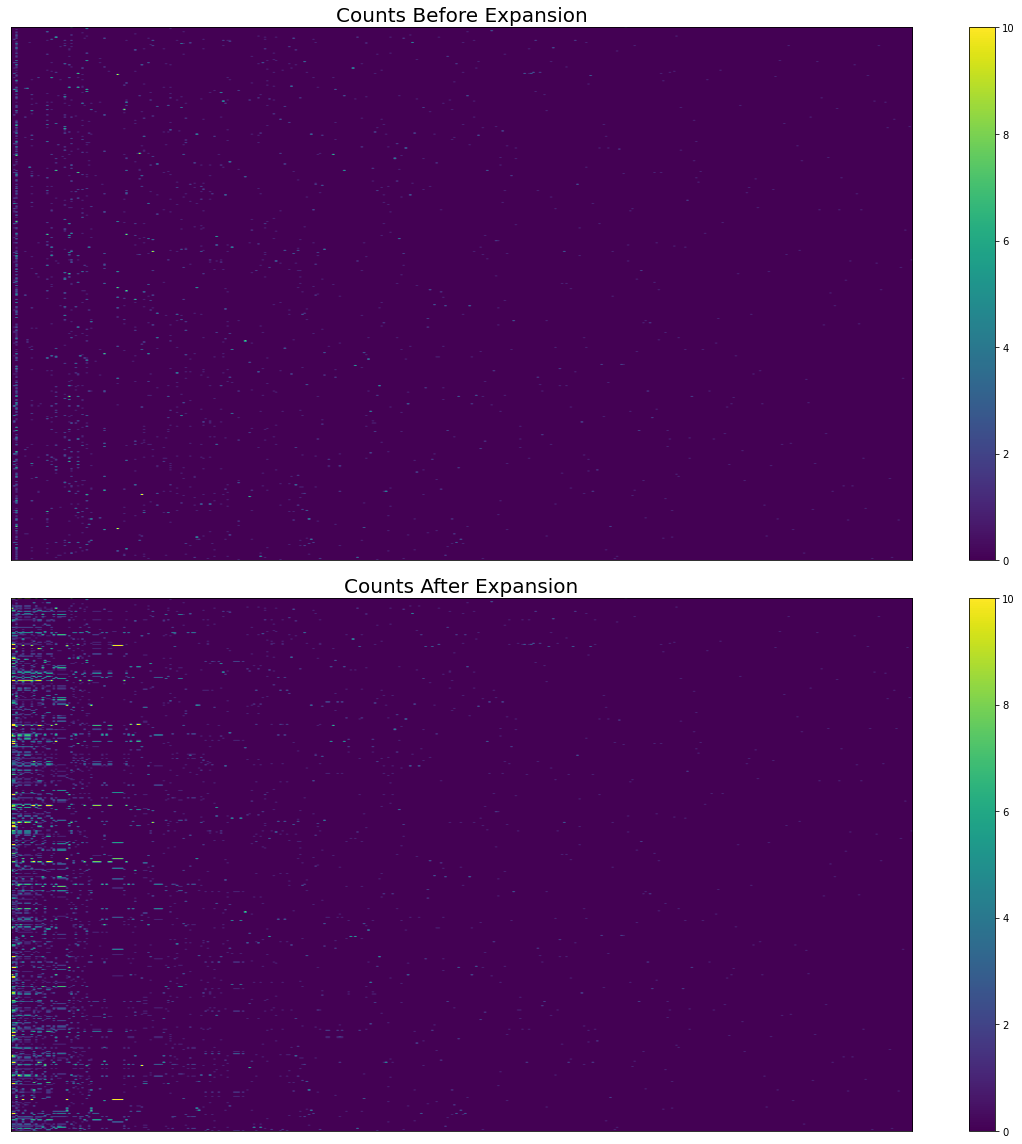

In [7]:
# Raw counts
fig, axes = plt.subplots(figsize=(16, 16), nrows=2, sharex=True)
pos = axes[0].imshow(
    cogat_counts_df[columns].values,
    aspect="auto",
    vmin=0,
    vmax=10,
)
fig.colorbar(pos, ax=axes[0])
axes[0].set_title("Counts Before Expansion", fontsize=20)
axes[0].yaxis.set_visible(False)
axes[0].xaxis.set_visible(False)
axes[0].set_ylabel("Study", fontsize=16)
axes[0].set_xlabel("Cognitive Atlas Term", fontsize=16)

# Expanded counts
pos = axes[1].imshow(
    expanded_df[columns].values,
    aspect="auto",
    vmin=0,
    vmax=10,
)
fig.colorbar(pos, ax=axes[1])
axes[1].set_title("Counts After Expansion", fontsize=20)
axes[1].yaxis.set_visible(False)
axes[1].xaxis.set_visible(False)
axes[1].set_ylabel("Study", fontsize=16)
axes[1].set_xlabel("Cognitive Atlas Term", fontsize=16)

fig.tight_layout()
glue("figure_cogat_expansion", fig, display=False)

In [8]:
# Here we delete the recent variables for the sake of reducing memory usage
del cogatlas, id_df, rel_df, cogat_counts_df, rep_text_df
del weights, expanded_df, series, columns

In [9]:
from nimare import annotate

lda_model = annotate.lda.LDAModel(
    neurosynth_dset_first_500.texts,
    text_column="abstract",
    n_topics=50,
    n_iters=10000,
)

# We will suppress MALLET's output when fitting the model, because MALLET logs a lot of information
import contextlib

with contextlib.redirect_stdout(None):
    lda_model.fit()

INFO:nimare.extract.utils:Dataset created in /home/data/nbc/misc-projects/Salo_NiMARE/data/mallet__temp


INFO:nimare.extract.utils:Dataset created in /home/data/nbc/misc-projects/Salo_NiMARE/data/mallet_model


INFO:nimare.annotate.lda:Texts folder not found. Creating text files...


INFO:nimare.annotate.lda:Generating topics...


Labels = 
   /home/data/nbc/misc-projects/Salo_NiMARE/data/mallet_model/texts


Data loaded.


Coded LDA: 50 topics, 6 topic bits, 111111 topic mask
max tokens: 244
total tokens: 59901


<10> LL/token: -8.72054
<20> LL/token: -8.4684


<30> LL/token: -8.36595
<40> LL/token: -8.29643



0	0.02	subjects cortex somatosensory stimulation fmri cortical study primary individual tactile evoked magnetic early blind investigated central mpfc found area 
1	0.02	priming attention faces stimulation early spatial passive observed vestibular modulated decreases regions multimodal touch swallowing greater simple lexical potential 
2	0.02	activity inferior regions subjects bilateral left temporal imaging resonance magnetic brain functional medial significant found superior gyri recognition comparison 
3	0.02	response visual regions attention cortex temporal events gyrus interference patterns activation anterior increased inhibition search contrast selectively resolution required 
4	0.02	human dorsal ventral magnetic region resonance condition suggest significantly regional complex superior multiple monkey properties number lobe structures occipital 
5	0.02	related responses imaging based areas cues preparation connectivity experiment showed elicited gyrus magnetic resonance chinese

<80> LL/token: -8.12487
<90> LL/token: -8.10972

0	0.02	cortex somatosensory stimulation cortical subjects fmri functional early primary activation tactile study individual evoked blind investigated found magnetic area 
1	0.02	attention spatial regions priming sensory modulated observed stimulus attended passive stimulation vestibular rate duration touch found swallowing decreases early 
2	0.02	subjects inferior activity regions temporal left cortex frontal bilateral brain magnetic prefrontal found imaging medial involved functional pattern fmri 
3	0.02	response attention regions attentional anterior interference visual activation gyrus required contrast events temporal inhibition selection search general activations english 
4	0.02	human dorsal ventral region resonance magnetic complex cingulate occipital suggest condition findings control based monkey multiple significantly number recordings 
5	0.02	showed imaging related responses resonance regions preparation based connectivity eff

<110> LL/token: -8.06538
<120> LL/token: -8.04734
<130> LL/token: -8.047


<140> LL/token: -8.02452

0	0.02	cortex fmri stimulation somatosensory activation subjects cortical functional early study individual primary observed magnetic tactile area blind subject evoked 
1	0.02	attention regions priming sensory modulated spatial attended passive repetition decreases modality found vestibular duration rate touch swallowing influences driven 
2	0.02	activity brain left regions inferior imaging subjects functional frontal cortex temporal involved bilateral magnetic medial found area task resonance 
3	0.02	attention response attentional visual interference anterior selection cortex regions gyrus activations control increased search selectively events induced inhibition contrast 
4	0.02	dorsal human region ventral resonance complex magnetic significantly findings suggest condition control cingulate based activate monkey multiple superior primarily 
5	0.02	imaging related resonance preparation magnetic responses connectivity based effective interaction experiment reg

<170> LL/token: -7.99287
<180> LL/token: -7.98215
<190> LL/token: -7.97106



0	0.02	cortex fmri somatosensory stimulation subjects cortical activation early functional area study tactile primary observed found individual magnetic subject blind 
1	0.02	attention regions sensory priming spatial modulated attended modality repetition passive vestibular enhanced reductions event extrastriate duration multimodal touch stimulation 
2	0.02	activity left bilateral imaging inferior magnetic functional regions frontal brain task resonance cortex found fmri temporal prefrontal medial involved 
3	0.02	attention response attentional visual interference selection cortex regions anterior induced inhibition events recruited activations target gyrus required control increased 
4	0.02	human dorsal ventral region resonance significantly complex functional suggest cingulate magnetic activate monkey properties multiple studies images condition cross 
5	0.02	visual related imaging magnetic experiment preparation cues resonance based connectivity effective showed responses sequences

<230> LL/token: -7.93207
<240> LL/token: -7.93446

0	0.02	cortex activation fmri somatosensory stimulation cortical functional subjects study primary early magnetic tactile individual area observed blind investigated subject 
1	0.02	attention priming regions sensory spatial modality modulated attended found passive repetition selective extrastriate vestibular reductions enhanced stimulus duration touch 
2	0.02	activity regions left cortex magnetic bilateral inferior fmri imaging resonance temporal frontal brain subjects involved found functional prefrontal superior 
3	0.02	attention response attentional anterior interference cortex target visual selection control induced search inhibition activations events general dimension selectively current 
4	0.02	human dorsal ventral functional region resonance magnetic complex significantly studies suggest condition activate occipital findings multiple neurons structures consistent 
5	0.02	imaging resonance showed preparation experiment magnetic

<260> LL/token: -7.92816
<270> LL/token: -7.92433
<280> LL/token: -7.91451


<290> LL/token: -7.90918

0	0.02	cortex activation fmri functional cortical somatosensory stimulation primary subjects early found resonance tactile individual study magnetic area observed blind 
1	0.02	attention spatial priming sensory regions attended repetition found modality passive modulated extrastriate high reductions duration modalities touch stimulation effects 
2	0.02	regions activity cortex bilateral imaging functional temporal inferior frontal brain resonance magnetic left involved found subjects prefrontal area superior 
3	0.02	attention response attentional visual interference anterior target cortex selection induced control events inhibition search gyrus significantly dimension increased current 
4	0.02	human dorsal ventral magnetic region functional suggest significantly complex resonance occipital activate multiple visual monkey studies neurons properties findings 
5	0.02	imaging regions resonance experiment related magnetic preparation responses connectivity demands s

<320> LL/token: -7.90066
<330> LL/token: -7.89594
<340> LL/token: -7.90229



0	0.02	cortex fmri activation somatosensory stimulation functional primary cortical early study magnetic individual tactile found subjects blind observed stimulus investigated 
1	0.02	attention priming sensory regions spatial modality passive modulated attended repetition reductions modalities found anatomically modulation event touch swallowing influences 
2	0.02	left activity regions inferior frontal bilateral temporal imaging cortex resonance magnetic functional fmri superior subjects involved brain found medial 
3	0.02	attention response attentional cortex target selection visual anterior regions interference control events induced inhibition feature search including dimension types 
4	0.02	human dorsal ventral resonance functional region suggest magnetic visual studies findings condition occipital significantly complex showed based activate monkey 
5	0.02	cortex related regions magnetic delay reward preparation demands imaging resonance connectivity experiment responses effective

<380> LL/token: -7.88501
<390> LL/token: -7.87837

0	0.02	cortex fmri somatosensory stimulation activation cortical primary magnetic functional individual resonance subjects early tactile found blind study evoked investigated 
1	0.02	attention sensory priming regions modality attended passive modulated spatial repetition found modalities anatomically extrastriate reductions multimodal touch unimodal modulation 
2	0.02	left frontal activity regions inferior functional bilateral imaging magnetic temporal brain prefrontal resonance superior cortex gyrus medial found involved 
3	0.02	attention response cortex attentional anterior visual selection target interference control search recruited inhibition regions selectively required including correlates dimension 
4	0.02	human dorsal ventral region functional magnetic studies suggest complex resonance visual condition activate occipital significantly humans findings based organization 
5	0.02	imaging related delay resonance regions reward pre

<410> LL/token: -7.87084
<420> LL/token: -7.87385
<430> LL/token: -7.86931


<440> LL/token: -7.85843

0	0.02	activation cortex fmri functional somatosensory stimulation cortical magnetic early primary study individual found resonance stimulus secondary tactile blind subject 
1	0.02	attention sensory priming regions modality repetition attended modulated modalities spatial passive tactile effects reductions anatomically found multimodal touch unimodal 
2	0.02	left activity regions temporal inferior frontal imaging magnetic gyrus functional bilateral resonance superior fmri cortex brain found observed medial 
3	0.02	attention response attentional selection target anterior visual interference cortex network control frontal search required inhibition relative general including dimension 
4	0.02	human dorsal ventral functional region resonance visual suggest studies magnetic complex involved activate findings monkey humans significantly neurons signals 
5	0.02	imaging related resonance reward responses preparation delay magnetic experiment based demands regions seq

<470> LL/token: -7.84592
<480> LL/token: -7.84635
<490> LL/token: -7.84402



0	0.02	cortex fmri activation functional stimulation cortical somatosensory early primary individual magnetic tactile found stimulus study resonance secondary subject blind 
1	0.02	regions attention priming modality sensory spatial attended modalities modulated effects passive posterior found repetition reductions touch anatomically unimodal decreases 
2	0.02	left frontal regions inferior bilateral temporal activity imaging functional gyrus resonance magnetic brain superior task neural cortex fmri involved 
3	0.02	attention response attentional cortex interference anterior selection visual control target inhibition search network dimension included events shifts selectively planning 
4	0.02	human dorsal functional ventral region resonance visual magnetic complex significantly humans activated condition suggest distinct multiple findings monkey activate 
5	0.02	reward preparation connectivity demands delay magnetic increased effective imaging regions sequences responses cognitive relat

<530> LL/token: -7.84474
<540> LL/token: -7.83418

0	0.02	fmri cortex activation functional stimulation magnetic cortical somatosensory early found resonance study primary stimulus subjects imaging area individual secondary 
1	0.02	attention priming modality sensory regions modalities attended passive specific effects spatial repetition modulated posterior tactile found reductions anatomically respond 
2	0.02	left temporal regions frontal inferior imaging magnetic resonance bilateral functional gyrus neural activity superior cortex found prefrontal involved fmri 
3	0.02	attention response attentional cortex visual anterior frontal interference selection control target inhibition search events selectively dimension color general induced 
4	0.02	human ventral dorsal functional region object suggest condition magnetic complex visual findings resonance humans significantly multiple monkey hypothesis distinct 
5	0.02	imaging regions magnetic related resonance preparation connectivity reward

<560> LL/token: -7.83529
<570> LL/token: -7.82741
<580> LL/token: -7.83207


<590> LL/token: -7.8259

0	0.02	cortex fmri functional activation stimulation cortical somatosensory magnetic early subjects primary contralateral resonance stimulus study tactile found individual subject 
1	0.02	regions sensory modality priming attention repetition specific passive modalities attended modulated spatial found effects reductions attentional anatomically tactile touch 
2	0.02	left frontal regions imaging inferior temporal activity cortex gyrus bilateral magnetic functional subjects resonance neural superior brain involved found 
3	0.02	attention response attentional interference visual selection control cortex anterior target selectively search dimension color inhibition relative network shifts events 
4	0.02	human dorsal ventral functional region object visual condition complex suggest resonance occipital humans monkey studies neurons activate signals properties 
5	0.02	regions reward preparation resonance connectivity imaging delay effective magnetic demands responses 

<620> LL/token: -7.82057
<630> LL/token: -7.82003
<640> LL/token: -7.8142



0	0.02	fmri cortex activation functional stimulation somatosensory cortical early study primary magnetic imaging contralateral stimulus found observed individual tactile subject 
1	0.02	regions modality priming sensory repetition attention spatial modalities passive posterior attended specific modulated effects reductions found tactile anatomically touch 
2	0.02	regions inferior left imaging frontal activity functional temporal gyrus brain bilateral resonance superior magnetic involved fmri found subjects medial 
3	0.02	attention response attentional visual interference selection anterior target frontal control inhibition search dimension selectively shifts types detection distractor feature 
4	0.02	human ventral dorsal object functional region studies resonance condition humans complex magnetic suggest visual role organization monkeys neurons monkey 
5	0.02	regions reward preparation resonance connectivity imaging effective delay magnetic sequences human responses demands cognitive i

<680> LL/token: -7.80113
<690> LL/token: -7.80491

0	0.02	activation fmri functional cortex cortical stimulation somatosensory magnetic imaging study resonance subjects found primary individual stimulus early tactile ipsilateral 
1	0.02	regions sensory attention priming modality repetition modalities modulated attended effects found specific reductions tactile anatomically passive unimodal attentional touch 
2	0.02	left frontal inferior regions imaging temporal bilateral functional gyrus magnetic activity resonance brain superior found neural fmri cortex medial 
3	0.02	attention response attentional selection target interference visual control frontal anterior search targets inhibition dimension change selectively color included posterior 
4	0.02	human dorsal ventral functional region object visual condition suggest resonance complex role significantly studies monkey monkeys signals humans magnetic 
5	0.02	reward preparation imaging connectivity resonance delay magnetic effective regio

<710> LL/token: -7.7984
<720> LL/token: -7.79981
<730> LL/token: -7.79056


<740> LL/token: -7.79037

0	0.02	cortex fmri activation functional stimulation cortical somatosensory magnetic imaging found primary subjects early individual resonance stimulus tactile study area 
1	0.02	regions modality sensory priming attention specific repetition modalities found modulated attended reductions effects anatomically tactile multimodal touch unimodal influences 
2	0.02	left regions inferior activity temporal frontal functional imaging magnetic resonance brain bilateral cortex subjects gyrus fmri neural superior medial 
3	0.02	attention response attentional frontal control selection interference anterior target visual inhibition search selectively feature dimension targets general shifts color 
4	0.02	human dorsal ventral functional object region condition visual complex humans suggest occipital monkeys multiple studies monkey magnetic activate significantly 
5	0.02	reward imaging resonance regions preparation connectivity effective delay related magnetic findings respo

<770> LL/token: -7.78783
<780> LL/token: -7.78644
<790> LL/token: -7.79008



0	0.02	cortex functional fmri activation cortical stimulation somatosensory magnetic imaging primary study subjects resonance found observed brain sii ipsilateral tactile 
1	0.02	regions modality priming attention sensory specific effects repetition modalities attended found reductions tactile anatomically modulated multimodal touch unimodal respond 
2	0.02	left activity regions temporal frontal inferior functional imaging gyrus bilateral brain magnetic resonance cortex fmri involved medial neural subjects 
3	0.02	attention response attentional anterior selection interference frontal visual control target search inhibition selectively feature dimension events targets shifts peripheral 
4	0.02	human dorsal ventral visual object functional condition studies region occipital complex suggest monkeys monkey neurons strongly properties function role 
5	0.02	regions resonance reward imaging preparation magnetic connectivity effective delay goal sequences findings visuomotor demands outcomes 

<830> LL/token: -7.78463
<840> LL/token: -7.77751

0	0.02	fmri activation cortex functional cortical stimulation somatosensory magnetic resonance subjects found study primary early sii stimulus representation ipsilateral present 
1	0.02	regions modality attention sensory priming specific modalities repetition effects found reductions tactile attended modulated cortical multimodal touch anatomically unimodal 
2	0.02	left inferior frontal temporal gyrus regions fmri imaging magnetic functional bilateral resonance involved brain activity superior neural cortex subjects 
3	0.02	attention response attentional anterior frontal selection interference target visual inhibition control search selectively color peripheral feature shifts planning targets 
4	0.02	human dorsal ventral region object visual functional condition studies complex sulcus humans occipital monkey strongly part properties signals neurons 
5	0.02	reward regions preparation connectivity delay imaging effective resonance magnet

<860> LL/token: -7.77775
<870> LL/token: -7.77746
<880> LL/token: -7.77198


<890> LL/token: -7.78083

0	0.02	fmri activation cortex cortical somatosensory functional stimulation subjects magnetic resonance contralateral stimulus primary found ipsilateral imaging sii early input 
1	0.02	regions priming modality specific attention sensory repetition modalities found tactile attended effects cortical reductions modulated multimodal touch anatomically decreases 
2	0.02	left inferior regions gyrus bilateral frontal imaging temporal brain magnetic resonance functional fmri neural superior activity subjects involved cortex 
3	0.02	attention response attentional frontal selection interference control anterior target inhibition visual search selectively color targets feature shifts peripheral planning 
4	0.02	human dorsal ventral functional object humans visual sulcus complex occipital region monkeys monkey part dimensional distinct neurons properties role 
5	0.02	regions reward preparation magnetic connectivity delay imaging human findings effective resonance visuomot

<920> LL/token: -7.7777
<930> LL/token: -7.7722
<940> LL/token: -7.77478



0	0.02	cortex fmri activation functional stimulation somatosensory subjects cortical magnetic found resonance si primary imaging early sii study brain contralateral 
1	0.02	sensory regions modality priming specific attention modalities attended cortical tactile effects found repetition reductions anatomically multimodal decreases unimodal touch 
2	0.02	left frontal temporal regions gyrus bilateral inferior fmri imaging functional magnetic resonance brain subjects superior activity involved cortex neural 
3	0.02	attention response attentional anterior interference frontal selection control target visual inhibition selectively search color shifts planning targets feature general 
4	0.02	human ventral dorsal object visual occipital humans complex functional sulcus region monkey surface neurons monkeys dimensional properties signals condition 
5	0.02	reward regions resonance preparation connectivity effective delay magnetic imaging sequences goal human demands outcomes monetary paradigm b

<980> LL/token: -7.77325
<990> LL/token: -7.77361

0	0.02	activation cortex fmri functional stimulation somatosensory cortical magnetic resonance primary found si subjects stimulus sii present study contralateral blind 
1	0.02	regions priming modality attention sensory specific modalities attended cortical repetition tactile effects reductions found decreases modulated multimodal touch unimodal 
2	0.02	left frontal regions functional inferior imaging gyrus resonance temporal magnetic brain cortex fmri bilateral subjects involved superior prefrontal anterior 
3	0.02	attention attentional response target interference selection visual control frontal selectively search dimension anterior feature inhibition shifts planning targets specific 
4	0.02	dorsal human ventral visual object occipital functional sulcus region complex humans condition dimensional activate monkey properties neurons monkeys objects 
5	0.02	regions reward preparation magnetic connectivity imaging resonance effective hum

<1010> LL/token: -7.76931
<1020> LL/token: -7.76736
<1030> LL/token: -7.75921


<1040> LL/token: -7.76903

0	0.02	activation fmri cortex stimulation cortical functional somatosensory magnetic primary imaging found study subjects si brain resonance contralateral ipsilateral sii 
1	0.02	regions sensory priming modality specific attention modalities repetition attended effects tactile found reductions cortical modulation anatomically familiar decreases integration 
2	0.02	left frontal regions imaging inferior gyrus resonance magnetic functional bilateral fmri temporal brain prefrontal cortex anterior superior found activity 
3	0.02	attention attentional response interference target selection frontal visual control dimension anterior color search specific feature required change shifts targets 
4	0.02	human dorsal ventral functional object visual occipital sulcus humans complex monkey properties condition activate objects dimensional neurons monkeys surface 
5	0.02	reward regions preparation connectivity imaging resonance effective including paradigm human sequences b

<1070> LL/token: -7.76179
<1080> LL/token: -7.7582
<1090> LL/token: -7.76817



0	0.02	activation fmri cortex functional stimulation somatosensory cortical magnetic resonance activated found primary subjects imaging si brain sii system stimulus 
1	0.02	modality priming sensory attention specific regions effects modalities repetition tactile attended cortical found reductions anatomically integration decreases touch passive 
2	0.02	left frontal regions inferior cortex imaging magnetic resonance functional gyrus fmri bilateral temporal involved brain subjects medial anterior prefrontal 
3	0.02	attention attentional response interference target visual selection frontal control anterior search selectively dimension change shifts detection feature color shift 
4	0.02	human dorsal ventral functional object sulcus visual humans complex occipital intraparietal condition monkey properties objects dimensional neurons monkeys surface 
5	0.02	reward resonance preparation connectivity effective magnetic paradigm imaging responses demands human goal outcomes monetary including

<1130> LL/token: -7.76132
<1140> LL/token: -7.75503

0	0.02	activation fmri cortex stimulation functional somatosensory magnetic cortical imaging primary contralateral si brain resonance subjects found sii stimulus tactile 
1	0.02	regions specific priming modality sensory attention modalities cortical attended effects repetition reductions tactile found anatomically decreases multimodal touch unimodal 
2	0.02	left frontal regions imaging inferior resonance magnetic gyrus brain functional bilateral temporal cortex fmri found superior subjects activity medial 
3	0.02	attention attentional response target visual interference selection control search frontal anterior selectively dimension detection color shifts feature change distractor 
4	0.02	human dorsal functional ventral object visual region sulcus humans surface monkey dimensional properties neurons monkeys occipital condition signals position 
5	0.02	regions reward magnetic resonance connectivity preparation imaging including effect

<1160> LL/token: -7.75695
<1170> LL/token: -7.75356
<1180> LL/token: -7.75595


<1190> LL/token: -7.7505

0	0.02	activation fmri cortex cortical functional stimulation somatosensory magnetic primary activated imaging resonance study subjects si stimulus contralateral brain sii 
1	0.02	regions modality specific priming sensory attention modalities repetition attended effects cortical tactile familiar reductions anatomically found unimodal touch respond 
2	0.02	frontal regions left imaging temporal inferior functional bilateral magnetic gyrus activity resonance fmri found anterior brain cortex subjects superior 
3	0.02	attention attentional response visual selection target interference search control frontal dimension selectively targets feature color shifts relevant distractor correlates 
4	0.02	human dorsal ventral functional object sulcus visual region humans occipital surface properties dimensional complex monkey intraparietal neurons monkeys position 
5	0.02	reward preparation connectivity resonance magnetic regions effective including imaging human goal paradi

<1220> LL/token: -7.7546
<1230> LL/token: -7.74904
<1240> LL/token: -7.7488



0	0.02	activation fmri functional cortical cortex stimulation somatosensory primary found resonance activated magnetic study si imaging subjects ipsilateral sii system 
1	0.02	modality priming sensory attention specific regions modalities repetition effects tactile cortical anterior found attended reductions familiar anatomically distinct multimodal 
2	0.02	frontal left regions imaging functional brain inferior gyrus magnetic cortex activity resonance temporal subjects fmri bilateral anterior involved control 
3	0.02	attention attentional response visual target interference selection search frontal control selectively dimension color inhibition attended shifts targets distractor evidence 
4	0.02	human ventral dorsal functional object sulcus visual intraparietal occipital humans part surface objects region monkey dimensional condition strongly monkeys 
5	0.02	regions reward preparation connectivity magnetic effective resonance goal imaging including human sequence sequences outcomes mo

<1280> LL/token: -7.74353
<1290> LL/token: -7.73994

0	0.02	activation fmri cortex functional somatosensory cortical magnetic stimulation primary activated found contralateral area ipsilateral si brain sii resonance study 
1	0.02	modality regions priming sensory specific modalities effects cortical repetition tactile attention attended found familiar reductions integration multimodal decreases unimodal 
2	0.02	left regions temporal imaging inferior frontal resonance bilateral cortex magnetic functional fmri gyrus brain anterior subjects found activity involved 
3	0.02	attention response attentional interference visual selection target control frontal search dimension selectively targets shifts detection feature attended time distractor 
4	0.02	human functional dorsal ventral object sulcus visual occipital intraparietal surface humans monkey monkeys neurons part properties position objects dimensional 
5	0.02	regions reward preparation connectivity effective magnetic resonance mpfc brai

<1310> LL/token: -7.74341
<1320> LL/token: -7.73791
<1330> LL/token: -7.73297


<1340> LL/token: -7.7441

0	0.02	activation fmri cortical somatosensory stimulation subjects cortex magnetic primary functional found si activated ipsilateral contralateral sii resonance area imaging 
1	0.02	regions modality priming specific sensory modalities repetition effects attention tactile cortical familiar anatomically attended found reductions multimodal touch unimodal 
2	0.02	left frontal regions functional inferior imaging bilateral magnetic gyrus fmri resonance temporal brain activity anterior control prefrontal found cortex 
3	0.02	attention response attentional interference visual selection frontal target selectively search control dimension attended color shifts change distractor dimensions shift 
4	0.02	human functional dorsal ventral visual area sulcus region object humans occipital intraparietal objects part monkeys surface properties dimensional complex 
5	0.02	reward regions connectivity preparation effective goal mpfc resonance brain imaging magnetic outcomes monet

<1370> LL/token: -7.7358
<1380> LL/token: -7.73261
<1390> LL/token: -7.73678



0	0.02	activation fmri stimulation cortical functional somatosensory cortex primary subjects contralateral ipsilateral si magnetic sii present activated area secondary sensory 
1	0.02	modality regions priming sensory specific effects modalities tactile attention repetition cortical found attentional reductions familiar anatomically touch unimodal mri 
2	0.02	left functional imaging temporal regions frontal cortex inferior magnetic resonance brain subjects gyrus fmri bilateral activity anterior involved found 
3	0.02	attention response attentional visual interference selection frontal target selectively attended control search dimension shifts detection distractor color evidence change 
4	0.02	human dorsal functional ventral area object sulcus visual intraparietal region objects humans occipital function signals surface complex hypothesis spatial 
5	0.02	reward connectivity goal regions human mpfc preparation effective behavior outcomes monetary brain interaction oriented driving prefe

<1430> LL/token: -7.73237
<1440> LL/token: -7.72935

0	0.02	activation fmri functional stimulation cortical somatosensory primary magnetic contralateral ipsilateral si subjects stimulus sii imaging cortex representation secondary study 
1	0.02	regions modality sensory priming specific effects modalities tactile repetition attention reductions cortical familiar distinct found attended anatomically attentional somatosensory 
2	0.02	left regions functional activity frontal imaging magnetic inferior resonance gyrus subjects bilateral cortex fmri anterior brain temporal found control 
3	0.02	attention attentional response interference visual selection control target selectively search attended dimension sensory color frontal shifts distractor required specific 
4	0.02	human area functional dorsal ventral sulcus visual object intraparietal humans region occipital complex monkeys surface objects spatial properties monkey 
5	0.02	reward connectivity goal preparation regions mpfc brain effectiv

<1460> LL/token: -7.73418
<1470> LL/token: -7.73192
<1480> LL/token: -7.72877


<1490> LL/token: -7.72794

0	0.02	activation fmri somatosensory primary stimulation subjects cortical functional brain contralateral cortex magnetic si representation sii stimulus study secondary system 
1	0.02	regions modality priming sensory specific modalities effects repetition tactile cortical reductions found familiar attention cortices anatomically touch respond unimodal 
2	0.02	left frontal regions imaging inferior functional magnetic resonance activity temporal anterior bilateral gyrus subjects found cortex brain fmri compared 
3	0.02	attention attentional response selection interference visual attended control frontal selectively target search dimension shifts color specific required greater distractor 
4	0.02	human functional area ventral dorsal object visual sulcus humans region surface intraparietal spatial objects function complex part premotor monkey 
5	0.02	reward regions brain connectivity goal mpfc preparation resonance effective behavior baseline outcomes monetary hu

<1520> LL/token: -7.73562
<1530> LL/token: -7.72464
<1540> LL/token: -7.72522



0	0.02	activation fmri primary cortical somatosensory stimulation magnetic cortex functional subjects contralateral found si ipsilateral stimulus activated sii study observed 
1	0.02	regions modality priming sensory specific modalities attention cortical tactile effects found cortices familiar repetition reductions anatomically attended touch unimodal 
2	0.02	left frontal functional imaging magnetic regions resonance cortex inferior subjects temporal activity bilateral control anterior gyrus found brain compared 
3	0.02	attention response attentional visual interference selection target control search selectively attended dimension relevant shifts color correlates time distractor enhanced 
4	0.02	human functional area ventral dorsal sulcus object humans function visual occipital surface intraparietal region objects complex part properties monkeys 
5	0.02	brain regions reward connectivity preparation goal mpfc effective behavior outcomes monetary oriented driving context activations in

<1580> LL/token: -7.7202
<1590> LL/token: -7.72631

0	0.02	activation fmri functional somatosensory stimulation cortical primary subjects magnetic cortex si contralateral found sii study brain ipsilateral stimulus present 
1	0.02	modality sensory priming regions specific effects repetition modalities attention cortices tactile familiar reductions anatomically attentional multimodal touch found unimodal 
2	0.02	regions left frontal imaging functional inferior magnetic resonance temporal gyrus bilateral cortex activity anterior fmri subjects brain found activated 
3	0.02	attention attentional response interference selection visual control subjects time target search performance dimension selectively color shifts detection distractor evidence 
4	0.02	human functional area sulcus object ventral dorsal visual intraparietal humans spatial occipital surface region function monkeys objects complex monkey 
5	0.02	reward brain connectivity regions mpfc effective preparation outcomes monetary con

<1610> LL/token: -7.72254
<1620> LL/token: -7.71975
<1630> LL/token: -7.72426


<1640> LL/token: -7.72801

0	0.02	activation fmri cortex somatosensory stimulation cortical functional subjects magnetic primary contralateral si activated present study brain sii ipsilateral secondary 
1	0.02	modality regions sensory specific effects modalities attention priming tactile repetition reductions familiar anatomically found distinct touch unimodal attentional somatosensory 
2	0.02	left functional frontal inferior gyrus imaging temporal magnetic regions activity anterior resonance cortex fmri subjects bilateral activated brain control 
3	0.02	attention attentional response interference selection visual attended control target search dimension selectively time shifts specific subjects shift distractor color 
4	0.02	human area functional ventral sulcus object dorsal intraparietal humans visual spatial region surface function complex objects monkeys properties part 
5	0.02	reward regions connectivity brain mpfc activations preparation goal effective outcomes monetary context m

<1670> LL/token: -7.71894
<1680> LL/token: -7.72046
<1690> LL/token: -7.71228



0	0.02	activation fmri stimulation cortical somatosensory functional cortex primary subjects magnetic imaging study brain si activated found sii present contralateral 
1	0.02	modality regions sensory specific attention modalities effects tactile familiar priming reductions cortical anatomically modulation touch decreases unimodal distinct multimodal 
2	0.02	left regions frontal functional subjects brain imaging inferior magnetic cortex fmri gyrus resonance anterior bilateral activity activated temporal involved 
3	0.02	attention attentional response interference selection attended control visual target search selectively subjects dimension observed required shifts evidence multiple distractor 
4	0.02	human area sulcus functional dorsal visual object intraparietal ventral humans surface function occipital complex region monkeys properties part hypothesis 
5	0.02	reward brain regions connectivity mpfc effective goal activations behavior preparation outcomes monetary driving oriented str

<1730> LL/token: -7.71868
<1740> LL/token: -7.7162

0	0.02	fmri activation somatosensory cortical functional stimulation cortex magnetic contralateral primary subjects resonance si study present ipsilateral sii brain sensory 
1	0.02	modality sensory regions specific attention modalities tactile priming effects found familiar reductions cortical anatomically attentional distinct multimodal touch unimodal 
2	0.02	left frontal regions subjects functional gyrus temporal fmri inferior cortex brain imaging magnetic anterior activity bilateral resonance found neural 
3	0.02	attention attentional response visual interference selection subjects attended control target search selectively dimension color shifts relevant observed time distractor 
4	0.02	area functional human sulcus dorsal object intraparietal ventral visual humans spatial function surface activated region part objects occipital monkeys 
5	0.02	reward regions connectivity brain mpfc effective preparation behavior goal outcomes mone

<1760> LL/token: -7.71888
<1770> LL/token: -7.7112
<1780> LL/token: -7.7079


<1790> LL/token: -7.71145

0	0.02	activation fmri stimulation somatosensory cortex cortical functional primary subjects study imaging si ipsilateral sii contralateral magnetic stimulus resonance activated 
1	0.02	regions modality sensory specific modalities effects attention tactile cortices priming familiar reductions independent found anatomically integration distinct touch selective 
2	0.02	left functional frontal subjects regions fmri cortex gyrus inferior temporal brain imaging resonance magnetic bilateral activity activated anterior neural 
3	0.02	attention attentional interference visual response selection selectively target control attended search dimension color time shifts observed distractor feature required 
4	0.02	human area sulcus dorsal ventral object intraparietal functional visual region humans part occipital surface function distinct objects monkey spatial 
5	0.02	reward connectivity brain effective mpfc regions goal preparation behavior outcomes monetary imitation de

<1820> LL/token: -7.71078
<1830> LL/token: -7.70585
<1840> LL/token: -7.70459



0	0.02	activation fmri cortical cortex stimulation somatosensory functional primary subjects magnetic ipsilateral si study imaging contralateral sii found studied activated 
1	0.02	modality sensory regions specific modalities effects priming tactile found familiar attention reductions cortical anatomically decreases multimodal touch unimodal attentional 
2	0.02	frontal subjects left functional regions imaging inferior brain magnetic fmri bilateral temporal gyrus activated resonance anterior involved activity found 
3	0.02	attention attentional response interference selection visual attended control selectively target color search dimension shifts relevant observed evidence shift distractor 
4	0.02	human area functional sulcus dorsal object ventral intraparietal visual humans surface region function objects distinct monkeys system monkey part 
5	0.02	reward brain connectivity effective mpfc behavior goal preparation cognitive activations outcomes monetary imitation default regions syst

<1880> LL/token: -7.70738
<1890> LL/token: -7.70391

0	0.02	activation fmri cortex stimulation functional somatosensory cortical primary brain magnetic subjects si found resonance ipsilateral sii studied study single 
1	0.02	modality regions sensory specific modalities tactile cortical cortices effects familiar priming reductions anatomically independent touch found unimodal multimodal passive 
2	0.02	left frontal functional subjects regions fmri imaging gyrus inferior temporal brain bilateral magnetic resonance activated activity cortex neural involved 
3	0.02	attention attentional response interference selection visual attended control selectively search dimension shifts target color distractor dimensions detection conjunction correlates 
4	0.02	human sulcus area functional dorsal ventral intraparietal object visual anterior region surface distinct occipital function humans part strongly monkeys 
5	0.02	reward regions connectivity brain effective mpfc preparation goal outcomes moneta

<1910> LL/token: -7.69962
<1920> LL/token: -7.69834
<1930> LL/token: -7.69951


<1940> LL/token: -7.7072

0	0.02	activation fmri cortex stimulation somatosensory cortical functional magnetic primary contralateral study si found activated subjects representation ipsilateral sii present 
1	0.02	regions modality specific sensory cortical modalities tactile effects priming attention reductions familiar cortices anatomically selective touch unimodal multimodal decreases 
2	0.02	frontal left subjects fmri gyrus functional temporal inferior regions imaging magnetic resonance activity brain bilateral cortex activated anterior neural 
3	0.02	attention attentional response interference visual selection attended selectively search dimension shift target control shifts color sensory distractor relevant dimensions 
4	0.02	human functional sulcus area dorsal object ventral intraparietal humans surface visual anterior function distinct region complex monkeys spatial monkey 
5	0.02	reward connectivity brain regions goal effective mpfc preparation cognitive study outcomes monetary

<1970> LL/token: -7.70163
<1980> LL/token: -7.70572
<1990> LL/token: -7.69671



0	0.02	activation fmri stimulation somatosensory cortical cortex magnetic brain primary study functional si contralateral activated subjects sii present ipsilateral resonance 
1	0.02	modality regions specific sensory modalities tactile effects priming familiar cortices reductions cortical anatomically attention selective multimodal touch unimodal modulation 
2	0.02	frontal subjects functional regions left imaging fmri gyrus inferior brain resonance temporal magnetic activity bilateral neural anterior cortex activated 
3	0.02	attention attentional response interference visual selection control attended selectively target search dimension shift color shifts greater observed sensory attending 
4	0.02	human sulcus functional area ventral object intraparietal dorsal humans visual surface anterior function lateral occipital distinct objects complex monkeys 
5	0.02	reward connectivity goal brain effective mpfc preparation activity oriented outcomes monetary imitation default context behavior

<2030> LL/token: -7.69865
<2040> LL/token: -7.69398

0	0.02	activation fmri cortical cortex stimulation somatosensory primary functional study magnetic brain si subjects contralateral ipsilateral sii present representation tms 
1	0.02	regions modality specific sensory modalities tactile priming familiar attention reductions anatomically cortices cortical parietal cross multimodal touch effects unimodal 
2	0.02	frontal functional subjects regions imaging left inferior magnetic temporal gyrus fmri cortex anterior resonance activated bilateral brain involved superior 
3	0.02	attention attentional response visual interference selection attended control search target dimension color shifts selectively greater distractor feature relevant dimensions 
4	0.02	functional human sulcus area object dorsal ventral intraparietal visual region humans function distinct surface organization occipital complex monkeys properties 
5	0.02	brain reward activity connectivity goal effective mpfc preparation ou

<2060> LL/token: -7.69814
<2070> LL/token: -7.69202
<2080> LL/token: -7.70052


<2090> LL/token: -7.69744

0	0.02	activation fmri stimulation cortex somatosensory functional cortical primary imaging magnetic subjects found study si ipsilateral sii single brain activated 
1	0.02	modality regions sensory modalities specific tactile attention priming effects cortical familiar reductions integration cortices anatomically cross found touch unimodal 
2	0.02	subjects frontal regions left cortex functional gyrus fmri temporal imaging anterior activated resonance inferior magnetic bilateral study brain involved 
3	0.02	attention attentional response visual interference selection search attended target control dimension shifts selectively color observed required correlates shift distractor 
4	0.02	human sulcus area functional object ventral intraparietal dorsal humans visual function distinct lateral spatial part properties occipital surface organization 
5	0.02	activity reward connectivity brain goal mpfc effective preparation preferentially outcomes monetary imitation def

<2120> LL/token: -7.69286
<2130> LL/token: -7.68917
<2140> LL/token: -7.68956



0	0.02	activation fmri cortex somatosensory stimulation cortical functional primary subjects magnetic si brain activated sii single study representation resonance ipsilateral 
1	0.02	modality regions sensory specific modalities tactile priming integration cortices cortical effects familiar attention anatomically cross reductions multimodal touch unimodal 
2	0.02	frontal cortex left subjects regions functional fmri gyrus imaging temporal magnetic inferior activated resonance brain anterior activity study bilateral 
3	0.02	attention attentional response interference selection attended search visual target dimension control color shifts feature top required selectively distractor greater 
4	0.02	human sulcus area object functional intraparietal dorsal ventral humans lateral visual region occipital distinct surface monkeys properties monkey dimensional 
5	0.02	activity reward brain connectivity goal effective mpfc preparation preferentially outcomes monetary imitation default driving beha

<2180> LL/token: -7.69201
<2190> LL/token: -7.69005

0	0.02	activation fmri cortex stimulation somatosensory cortical primary activated subjects functional contralateral si study imaging magnetic single sii found ipsilateral 
1	0.02	regions modality sensory specific modalities tactile priming effects integration attention cortical familiar anatomically cross reductions multimodal touch selective unimodal 
2	0.02	frontal left functional subjects imaging cortex regions temporal inferior fmri gyrus brain magnetic anterior activated resonance bilateral neural prefrontal 
3	0.02	attention attentional visual response interference selection control attended executive shift target search dimension color selectively shifts intraparietal distractor dimensions 
4	0.02	human sulcus area functional object ventral dorsal intraparietal humans distinct lateral surface region function properties complex monkeys monkey dimensional 
5	0.02	activity brain reward connectivity goal mpfc preparation effectiv

<2210> LL/token: -7.6934
<2220> LL/token: -7.68185
<2230> LL/token: -7.69653


<2240> LL/token: -7.68785

0	0.02	activation fmri cortex somatosensory cortical primary stimulation subjects study magnetic si activated functional contralateral sii ipsilateral found representation tms 
1	0.02	modality regions sensory specific modalities effects cortices priming tactile integration familiar reductions attention anatomically cross multimodal touch cortical unimodal 
2	0.02	cortex frontal regions functional temporal left subjects gyrus inferior fmri imaging resonance magnetic anterior brain activity superior bilateral neural 
3	0.02	attention attentional response visual interference selection attended executive search control dimension shift shifts selectively color required top dimensions multiple 
4	0.02	human area sulcus functional object dorsal intraparietal ventral region humans spatial surface dimensional lateral distinct monkeys monkey properties complex 
5	0.02	reward activity brain connectivity goal mpfc effective preparation preferentially subjects outcomes mo

<2270> LL/token: -7.68971
<2280> LL/token: -7.68908
<2290> LL/token: -7.68221



0	0.02	activation fmri cortex somatosensory stimulation primary cortical motor si contralateral functional subjects sii study activated input ipsilateral present tms 
1	0.02	modality regions sensory specific modalities attention tactile effects cortices reductions integration familiar anatomically priming cross multimodal touch unimodal selective 
2	0.02	frontal subjects left regions functional cortex temporal gyrus fmri imaging parietal inferior magnetic anterior resonance activated neural bilateral superior 
3	0.02	attention attentional response selection interference visual search attended dimension executive shift target control shifts color selectively dimensions targets conjunction 
4	0.02	human sulcus functional area object dorsal intraparietal ventral humans region lateral visual surface distinct objects spatial organization part properties 
5	0.02	activity reward brain connectivity effective goal mpfc subjects outcomes monetary imitation default preferentially preparation dri

<2330> LL/token: -7.68799
<2340> LL/token: -7.68674

0	0.02	activation fmri cortex somatosensory stimulation cortical primary contralateral motor si sii activated magnetic functional study subjects ipsilateral hand single 
1	0.02	modality sensory regions modalities specific effects priming tactile integration attention familiar cortices cross multimodal touch respond unimodal selective anatomically 
2	0.02	cortex left frontal subjects temporal functional regions gyrus imaging magnetic brain fmri parietal resonance inferior activated bilateral neural anterior 
3	0.02	attention attentional response interference visual selection target executive search attended control dimension shift selectively shifts color greater top dimensions 
4	0.02	human sulcus functional area object dorsal intraparietal ventral region humans surface lateral distinct part anterior complex spatial organization monkeys 
5	0.02	activity reward connectivity brain mpfc goal effective outcomes monetary imitation default

<2360> LL/token: -7.68785
<2370> LL/token: -7.67975
<2380> LL/token: -7.68063


<2390> LL/token: -7.67963

0	0.02	activation fmri stimulation somatosensory cortex primary cortical motor activated si contralateral study subjects sii single magnetic hand tms observed 
1	0.02	modality regions sensory specific modalities tactile effects priming familiar attention integration cortical anatomically cross touch selective unimodal multimodal attentional 
2	0.02	left frontal cortex regions subjects functional parietal activated gyrus inferior temporal imaging fmri resonance magnetic brain neural bilateral results 
3	0.02	attention attentional response interference selection target attended control visual search executive shift selectively dimension targets shifts greater feature dimensions 
4	0.02	human area sulcus functional object dorsal ventral intraparietal humans region surface anterior imaging lateral visual complex part monkeys properties 
5	0.02	activity reward connectivity effective goal mpfc brain outcomes monetary imitation default oriented preparation driving s

<2420> LL/token: -7.67985
<2430> LL/token: -7.67794
<2440> LL/token: -7.68334



0	0.02	activation fmri somatosensory cortex stimulation motor primary contralateral cortical subjects si functional sii study magnetic ipsilateral observed tms sensory 
1	0.02	regions modality sensory specific modalities cortices integration tactile effects familiar priming anatomically cross multimodal touch unimodal cortical modal crossmodal 
2	0.02	cortex frontal subjects left regions functional parietal fmri brain gyrus temporal activated magnetic anterior inferior imaging resonance involved prefrontal 
3	0.02	attention attentional response interference selection control visual search attended executive target greater dimension shift selectively targets shifts correlates top 
4	0.02	human area sulcus functional object ventral dorsal intraparietal region humans imaging surface organization part distinct visual complex spatial monkeys 
5	0.02	activity reward connectivity brain mpfc effective goal outcomes monetary imitation default behavior suggest striatum driving significant study

<2480> LL/token: -7.67632
<2490> LL/token: -7.67716

0	0.02	activation fmri cortex somatosensory stimulation primary cortical motor si study magnetic functional sii contralateral ipsilateral sensory activated observed representation 
1	0.02	modality regions sensory specific modalities priming integration tactile effects cortices familiar anatomically cross selective multimodal touch unimodal modal crossmodal 
2	0.02	cortex subjects frontal regions functional left temporal fmri parietal gyrus resonance inferior activated imaging magnetic brain anterior superior neural 
3	0.02	attention attentional response selection interference attended target executive selectively dimension search targets color greater control shifts shift required top 
4	0.02	human functional sulcus object area ventral dorsal intraparietal visual spatial region surface organization imaging part dimensional lateral complex distinct 
5	0.02	activity reward connectivity brain goal effective mpfc outcomes monetary imitat

<2510> LL/token: -7.67761
<2520> LL/token: -7.67387
<2530> LL/token: -7.68039


<2540> LL/token: -7.67403

0	0.02	activation cortex fmri somatosensory motor stimulation cortical si primary contralateral sii magnetic activated functional tms ipsilateral single input present 
1	0.02	modality regions sensory specific modalities priming tactile effects cortices cortical integration auditory familiar cross multimodal touch unimodal modulation anatomically 
2	0.02	cortex subjects frontal left regions parietal functional brain imaging fmri temporal magnetic gyrus resonance activated involved neural inferior bilateral 
3	0.02	attention attentional response interference selection attended target executive dimension shift selectively search color top attending shifts greater intraparietal targets 
4	0.02	human sulcus functional area object ventral dorsal intraparietal visual humans imaging surface region dimensional anterior organization spatial part distinct 
5	0.02	activity reward connectivity brain goal mpfc effective actions outcomes monetary imitation default driving p

<2570> LL/token: -7.67219
<2580> LL/token: -7.66773
<2590> LL/token: -7.67226



0	0.02	activation fmri somatosensory stimulation cortex motor primary cortical si contralateral activated sii hand functional subjects brain single tms input 
1	0.02	regions modality sensory specific auditory modalities tactile integration priming cortices cortical familiar cross multimodal touch effects unimodal modulation independent 
2	0.02	cortex subjects frontal left functional brain regions fmri imaging parietal temporal gyrus resonance involved magnetic activated results neural inferior 
3	0.02	attention attentional interference response selection attended executive dimension shift target search attending shifts selectively required intraparietal greater relevant dimensions 
4	0.02	human area functional sulcus object ventral dorsal intraparietal region visual humans surface dimensional distinct monkeys central imaging monkey properties 
5	0.02	activity reward connectivity brain actions mpfc effective goal outcomes monetary imitation default driving influenced cbt playing refere

<2630> LL/token: -7.67395
<2640> LL/token: -7.67423

0	0.02	activation fmri somatosensory motor cortex stimulation cortical primary subjects si contralateral sii activated single tms ipsilateral hand tactile secondary 
1	0.02	regions modality sensory specific cortical auditory modalities integration tactile priming familiar effects cross multimodal touch anatomically unimodal mri modal 
2	0.02	cortex left subjects frontal regions functional brain fmri parietal resonance gyrus results imaging magnetic temporal inferior activated neural involved 
3	0.02	attention attentional response interference selection target motor attended selectively dimension shifts color event search required intraparietal dimensions shift targets 
4	0.02	functional human object ventral area sulcus dorsal region intraparietal surface objects lateral distinct visual humans spatial dimensional properties monkeys 
5	0.02	activity reward connectivity actions brain effective mpfc goal outcomes monetary imitation defau

<2660> LL/token: -7.65992
<2670> LL/token: -7.66046


<2680> LL/token: -7.66586
<2690> LL/token: -7.66279

0	0.02	activation fmri somatosensory cortex motor stimulation si primary sii contralateral cortical functional hand representation ipsilateral tms subjects secondary activated 
1	0.02	regions modality sensory modalities tactile integration priming familiar cortical modulation cortices effects auditory cross multimodal touch specific unimodal anatomically 
2	0.02	cortex left frontal subjects functional regions parietal brain fmri activated resonance gyrus imaging magnetic results inferior areas neural involved 
3	0.02	attention attentional response interference attended selection event motor selectively dimension shift required shifts search color top dimensions targets feature 
4	0.02	human sulcus area functional object intraparietal ventral dorsal region humans surface visual objects dimensional lateral complex part monkeys distinct 
5	0.02	activity reward connectivity brain goal mpfc effective actions outcomes monetary imitation de

<2710> LL/token: -7.66376
<2720> LL/token: -7.66505
<2730> LL/token: -7.66204


<2740> LL/token: -7.66245

0	0.02	activation fmri somatosensory cortex stimulation motor primary cortical si sii subjects ipsilateral sensory tms functional hand secondary input tactile 
1	0.02	modality regions sensory modalities tactile integration auditory specific priming familiar stimulus cortical anatomically multimodal touch cross unimodal cortices modal 
2	0.02	cortex frontal left functional brain regions parietal subjects imaging fmri resonance magnetic results activated inferior gyrus anterior areas neural 
3	0.02	attention attentional response interference selection attended relevant search dimension shift selectively motor greater target attending shifts targets resolution required 
4	0.02	human functional sulcus area object ventral intraparietal dorsal lateral region distinct surface part visual objects humans dimensional organization monkeys 
5	0.02	activity reward connectivity goal mpfc actions effective outcomes monetary imitation default suggest driving cbt loss referen

<2770> LL/token: -7.6627
<2780> LL/token: -7.66002
<2790> LL/token: -7.65732



0	0.02	activation somatosensory cortex fmri stimulation motor primary si cortical contralateral sii single tms functional input ipsilateral secondary tactile representation 
1	0.02	modality regions sensory specific modalities auditory integration tactile priming stimulus familiar cortical modulation cross effects anatomically multimodal touch unimodal 
2	0.02	cortex functional left subjects frontal regions brain parietal temporal fmri imaging activated magnetic gyrus resonance neural involved inferior posterior 
3	0.02	attention attentional response interference selection attended search dimension shift stroop targets shifts selectively target top relevant required motor color 
4	0.02	human functional sulcus area object ventral intraparietal dorsal visual lateral distinct surface region objects humans dimensional organization complex location 
5	0.02	activity reward connectivity goal mpfc actions effective outcomes monetary imitation default behavior driving preferentially suggest cbt

<2830> LL/token: -7.65334
<2840> LL/token: -7.65303

0	0.02	activation stimulation somatosensory motor fmri cortex si primary contralateral cortical sii hand single ipsilateral tms tactile sensory secondary representation 
1	0.02	modality regions sensory modalities priming cortices integration tactile familiar auditory cross stimulus multimodal touch effects cortical unimodal specific modal 
2	0.02	cortex left subjects frontal regions functional brain activated imaging fmri parietal involved magnetic resonance areas gyrus temporal results inferior 
3	0.02	attention attentional response interference selection search attended motor selectively relevant dimension shifts feature color top time systems required attending 
4	0.02	human sulcus functional area object ventral dorsal intraparietal region objects lateral surface visual distinct humans dimensional organization monkeys complex 
5	0.02	activity reward connectivity goal actions mpfc effective monetary imitation default preferentially

<2860> LL/token: -7.66174
<2870> LL/token: -7.65613
<2880> LL/token: -7.65595


<2890> LL/token: -7.65491

0	0.02	activation fmri somatosensory stimulation motor cortex cortical primary si contralateral hand sii ipsilateral single tms input tactile secondary representation 
1	0.02	modality regions visual sensory modalities priming tactile specific integration cortices effects stimulus familiar cross multimodal touch auditory unimodal independent 
2	0.02	cortex frontal left functional regions subjects brain parietal fmri imaging activated magnetic gyrus involved resonance areas temporal anterior results 
3	0.02	attention attentional response interference selection stroop attended search motor relevant dimension selectively target systems shifts targets executive color attending 
4	0.02	human sulcus functional object area ventral dorsal intraparietal region visual humans distinct surface dimensional objects location monkeys organization lateral 
5	0.02	reward activity actions connectivity mpfc effective goal outcomes monetary imitation default driving including inte

<2920> LL/token: -7.65366
<2930> LL/token: -7.64629
<2940> LL/token: -7.6523



0	0.02	activation somatosensory fmri stimulation motor cortex cortical primary si hand contralateral sii ipsilateral single tms secondary tactile representation system 
1	0.02	modality visual regions sensory auditory modalities specific integration tactile cortical cortices familiar cross touch effects unimodal modulation stimulus multimodal 
2	0.02	cortex frontal regions functional left subjects parietal imaging fmri brain results activated resonance gyrus areas magnetic involved temporal anterior 
3	0.02	attention attentional response interference selection stroop relevant motor search attended event executive dimension selectively attending shifts targets factors time 
4	0.02	human sulcus functional area ventral object intraparietal dorsal region humans visual distinct objects surface dimensional spatial complex part lateral 
5	0.02	activity reward actions connectivity mpfc goal including effective behavior outcomes monetary imitation default striatum driving preferentially oriente

<2980> LL/token: -7.65154
<2990> LL/token: -7.6532

0	0.02	activation motor somatosensory stimulation cortex fmri contralateral si primary cortical sii single sensory ipsilateral hand tactile tms input secondary 
1	0.02	modality regions visual sensory auditory modalities specific integration tactile cortices cortical effects familiar cross modulation multimodal touch change unimodal 
2	0.02	cortex frontal functional left regions fmri parietal magnetic brain imaging subjects resonance activated areas gyrus bilateral temporal results neural 
3	0.02	attention attentional response interference selection stroop attended executive motor relevant event time search dimension selectively targets shifts required attending 
4	0.02	human sulcus functional area object intraparietal ventral dorsal humans region distinct surface part dimensional visual objects location properties monkeys 
5	0.02	activity reward actions connectivity goal mpfc behavior effective outcomes monetary imitation default incl

<3010> LL/token: -7.64234
<3020> LL/token: -7.64657
<3030> LL/token: -7.64069


<3040> LL/token: -7.64474

0	0.02	activation motor somatosensory fmri stimulation cortex cortical primary si contralateral sii hand ipsilateral tms secondary input tactile sensory single 
1	0.02	modality visual regions sensory modalities auditory tactile integration cortical effects familiar cross modulation multimodal touch speed unimodal stimulus specific 
2	0.02	cortex frontal left functional regions imaging parietal brain areas activated magnetic fmri resonance involved subjects bilateral results temporal gyrus 
3	0.02	attention attentional response interference selection stroop event attended selectively executive relevant dimension search attending shifts motor factors color required 
4	0.02	human sulcus area functional object intraparietal dorsal humans ventral visual distinct region surface lateral objects dimensional spatial monkeys properties 
5	0.02	activity reward actions connectivity goal mpfc behavior effective including outcomes monetary imitation default striatum drivin

<3070> LL/token: -7.64157
<3080> LL/token: -7.64032
<3090> LL/token: -7.64148



0	0.02	activation somatosensory fmri motor stimulation cortex cortical contralateral si sii hand sensory ipsilateral single primary tms secondary tactile representation 
1	0.02	modality regions sensory modalities tactile integration auditory familiar cortical visual cross independent effects specific modulation multimodal touch unimodal modal 
2	0.02	cortex frontal left functional regions brain fmri activated parietal imaging resonance involved subjects magnetic gyrus results areas posterior bilateral 
3	0.02	attention attentional interference response selection stroop attended search dimension time attending shifts shift selectively top sensory event executive motor 
4	0.02	human area sulcus object functional dorsal ventral intraparietal visual region humans lateral surface dimensional part location distinct properties monkeys 
5	0.02	activity reward connectivity actions mpfc goal behavior effective outcomes monetary imitation default including driving striatum cbt referential reward

<3130> LL/token: -7.63617
<3140> LL/token: -7.63459

0	0.02	activation motor somatosensory fmri stimulation contralateral cortex primary si sii cortical sensory tms ipsilateral hand tactile input single secondary 
1	0.02	modality visual sensory auditory modalities regions integration tactile specific familiar cross stimulus multimodal cortical anatomically unimodal touch modulation effects 
2	0.02	cortex frontal regions left functional brain subjects areas parietal fmri imaging activated resonance magnetic results involved anterior temporal gyrus 
3	0.02	attention attentional response interference selection attended stroop event executive motor relevant dimension target search time shifts selectively selective top 
4	0.02	human area functional sulcus object ventral dorsal intraparietal posterior visual humans region location surface dimensional objects lateral part spatial 
5	0.02	activity actions reward connectivity goal mpfc behavior including effective monetary imitation default out

<3160> LL/token: -7.63534
<3170> LL/token: -7.63315
<3180> LL/token: -7.63078


<3190> LL/token: -7.63416

0	0.02	activation motor cortex somatosensory fmri stimulation si sensory contralateral primary cortical sii hand tms ipsilateral input secondary single representation 
1	0.02	modality visual sensory integration specific auditory modalities regions tactile familiar cortical cross effects touch anatomically unimodal multimodal modal crossmodal 
2	0.02	cortex regions left frontal functional subjects parietal imaging fmri brain activated magnetic areas resonance involved gyrus neural results temporal 
3	0.02	attention attentional response interference selection attended search executive time event dimension top shifts selectively sensory motor factors shift multiple 
4	0.02	human functional area sulcus ventral posterior object dorsal intraparietal humans visual region spatial surface location lateral dimensional properties monkeys 
5	0.02	activity reward connectivity actions goal mpfc effective behavior outcomes monetary imitation default demanding ventral drivin

<3220> LL/token: -7.62707
<3230> LL/token: -7.63147
<3240> LL/token: -7.62908



0	0.02	activation motor somatosensory cortex stimulation fmri primary hand contralateral si sii cortical single ipsilateral tms sensory input secondary tactile 
1	0.02	visual modality regions sensory integration modalities tactile auditory familiar cross multimodal touch anatomically unimodal effects specific interactions modal crossmodal 
2	0.02	cortex regions frontal functional subjects areas fmri left brain imaging activated parietal magnetic results resonance involved study gyrus temporal 
3	0.02	attention attentional response interference selection attended search executive motor shift event dimension selectively top sensory time shifts color relevant 
4	0.02	human sulcus area object dorsal functional humans posterior intraparietal ventral region lateral visual surface dimensional specific objects location monkeys 
5	0.02	activity reward connectivity mpfc goal actions effective behavior ventral outcomes monetary imitation default driving suggest cbt loss referential rewards 
6	0.

<3280> LL/token: -7.62062
<3290> LL/token: -7.6269

0	0.02	activation motor somatosensory cortex stimulation fmri primary si hand sii contralateral sensory cortical ipsilateral single tms input tactile representation 
1	0.02	modality visual regions sensory auditory integration modalities specific tactile familiar cross multimodal touch cortical unimodal respond independent modal crossmodal 
2	0.02	cortex functional subjects areas regions frontal left imaging fmri brain activated parietal magnetic activation results temporal resonance involved gyrus 
3	0.02	attention attentional response interference selection attended motor event search top executive dimension shift sensory selectively selective shifts time target 
4	0.02	human sulcus object area dorsal intraparietal ventral humans functional posterior region lateral spatial visual surface information location objects part 
5	0.02	activity reward actions connectivity mpfc goal effective ventral behavior monetary imitation default sugge

<3310> LL/token: -7.61892
<3320> LL/token: -7.62084
<3330> LL/token: -7.62256


<3340> LL/token: -7.62094

0	0.02	activation motor somatosensory stimulation fmri primary cortical contralateral cortex si sii hand ipsilateral input tms secondary sensory tactile limb 
1	0.02	modality regions visual sensory integration auditory modalities specific tactile familiar respond anatomically cross multimodal touch unimodal independent cortical modal 
2	0.02	cortex activation functional regions subjects frontal left fmri brain areas imaging parietal activated magnetic resonance temporal anterior results gyrus 
3	0.02	attention attentional response interference selection attended motor executive sensory search event time target top dimension shift shifts selectively required 
4	0.02	human sulcus area object ventral intraparietal visual dorsal humans functional lateral region posterior surface objects spatial location part dimensional 
5	0.02	reward activity connectivity actions mpfc goal ventral effective behavior including monetary imitation default cognitive outcomes driving

<3370> LL/token: -7.61398
<3380> LL/token: -7.61131
<3390> LL/token: -7.61798



0	0.02	activation motor somatosensory cortex fmri stimulation primary hand si sii contralateral sensory ipsilateral tms cortical tactile representation input secondary 
1	0.02	modality visual sensory regions modalities auditory tactile specific integration cortical familiar cross respond multimodal touch unimodal modulation effects somatosensory 
2	0.02	cortex activation functional subjects regions fmri left frontal parietal areas imaging brain temporal activated resonance results magnetic involved neural 
3	0.02	attention attentional response interference selection attended stroop executive time search motor relevant dimension shift event shifts selectively top required 
4	0.02	human sulcus object functional posterior area ventral intraparietal dorsal humans visual region surface location specific objects spatial lateral dimensional 
5	0.02	activity reward connectivity actions mpfc goal effective behavior outcomes monetary imitation default ventral including driving directed neuronal

<3430> LL/token: -7.61688
<3440> LL/token: -7.60905

0	0.02	activation motor somatosensory stimulation fmri cortex hand cortical contralateral primary si sensory sii ipsilateral single tms secondary input sensorimotor 
1	0.02	modality regions sensory modalities visual specific auditory tactile cortical integration familiar cross multimodal attentional touch respond unimodal modal crossmodal 
2	0.02	cortex functional activation frontal fmri regions subjects parietal left imaging areas brain magnetic activated resonance results involved anterior temporal 
3	0.02	attention attentional response interference selection attended stroop search event motor executive dimension time shift target intraparietal relevant selectively systems 
4	0.02	human sulcus object area ventral dorsal region intraparietal visual functional humans spatial posterior objects lateral surface location orientation part 
5	0.02	activity reward connectivity goal actions mpfc effective ventral behavior outcomes monetary i

<3460> LL/token: -7.61046
<3470> LL/token: -7.61182
<3480> LL/token: -7.60987


<3490> LL/token: -7.61455

0	0.02	activation motor somatosensory fmri stimulation cortex cortical hand si contralateral primary sii ipsilateral tms single tactile secondary sensory limb 
1	0.02	modality regions sensory auditory visual modalities specific tactile cortical familiar anatomically cross integration somatosensory touch unimodal multimodal modal crossmodal 
2	0.02	cortex activation functional subjects frontal brain left fmri regions parietal imaging areas activated magnetic resonance results neural anterior temporal 
3	0.02	attention attentional response interference selection attended stroop motor search event dimension shift selectively target top intraparietal attending shifts selective 
4	0.02	human area sulcus object functional intraparietal dorsal spatial posterior ventral visual humans surface objects location specific part dimensional complex 
5	0.02	activity reward connectivity actions effective goal ventral mpfc behavior monetary imitation default outcomes driving m

<3520> LL/token: -7.60539
<3530> LL/token: -7.6121
<3540> LL/token: -7.60153



0	0.02	activation motor somatosensory cortex fmri stimulation cortical contralateral si sii primary ipsilateral sensory tms hand tactile input representation limb 
1	0.02	regions modality visual sensory modalities integration specific auditory tactile familiar anatomically cross multimodal touch occipito unimodal independent interactions modal 
2	0.02	cortex functional activation brain subjects left frontal parietal fmri imaging magnetic regions activated areas resonance results involved neural bilateral 
3	0.02	attention attentional response interference selection attended motor stroop search executive dimension event shifts selectively top intraparietal attending required relevant 
4	0.02	human area sulcus object functional posterior ventral intraparietal humans dorsal location visual spatial surface objects region part lateral orientation 
5	0.02	activity reward connectivity actions regions goal mpfc effective behavior ventral outcomes monetary imitation default driving mode cbt lo

<3580> LL/token: -7.60377
<3590> LL/token: -7.60394

0	0.02	activation motor somatosensory cortex stimulation hand fmri contralateral si primary cortical ipsilateral sii sensory tms hemisphere secondary representation tactile 
1	0.02	modality regions sensory integration modalities auditory tactile specific visual familiar multimodal touch unimodal influences anatomically cross interactions modal crossmodal 
2	0.02	cortex functional activation brain fmri regions subjects imaging left parietal frontal magnetic areas activated results resonance prefrontal neural involved 
3	0.02	attention attentional response interference selection attended motor stroop dimension top selectively attending shifts target search shift color sensory event 
4	0.02	human area object sulcus posterior visual intraparietal spatial functional humans surface lateral single location objects region part properties ventral 
5	0.02	activity reward actions connectivity effective goal mpfc regions behavior outcomes moneta

<3610> LL/token: -7.60259
<3620> LL/token: -7.60065
<3630> LL/token: -7.60182


<3640> LL/token: -7.59573

0	0.02	activation motor cortex somatosensory fmri stimulation hand cortical si contralateral primary sii ipsilateral tms secondary tactile sensory representation limb 
1	0.02	modality visual regions sensory modalities integration specific tactile auditory familiar cross multimodal touch anatomically unimodal respond independent modal crossmodal 
2	0.02	cortex functional activation brain left imaging parietal frontal regions areas subjects fmri resonance magnetic results activated study involved gyrus 
3	0.02	attention attentional response interference selection attended stroop event search dimension attending shifts selectively shift motor selective factors target top 
4	0.02	human area object sulcus intraparietal ventral humans dorsal spatial surface location posterior region lateral objects visual functional dimensional monkeys 
5	0.02	activity reward connectivity mpfc goal actions effective behavior ventral outcomes monetary imitation default driving state

<3670> LL/token: -7.59533
<3680> LL/token: -7.5955
<3690> LL/token: -7.59343



0	0.02	motor activation somatosensory stimulation fmri cortex primary cortical contralateral si hand sii ipsilateral sensory tms secondary body tactile limb 
1	0.02	modality visual regions sensory modalities specific auditory integration tactile familiar cross mri multimodal touch respond unimodal speed influences independent 
2	0.02	cortex functional activation brain subjects left fmri frontal areas parietal regions imaging activated magnetic resonance results study involved bilateral 
3	0.02	attention attentional response interference selection attended stroop motor color selective dimension time shift selectively target top shifts sensory search 
4	0.02	human area sulcus object posterior functional intraparietal spatial visual ventral lateral surface location single humans dorsal objects dimensional monkeys 
5	0.02	activity reward connectivity mpfc actions goal effective state outcomes monetary imitation default ventral driving behavior suggest directed cbt loss 
6	0.02	motion stim

<3730> LL/token: -7.59647
<3740> LL/token: -7.59055

0	0.02	activation motor somatosensory cortex stimulation hand primary fmri si contralateral sii sensory cortical ipsilateral tms tactile secondary body passive 
1	0.02	modality visual regions modalities integration sensory specific auditory tactile mri familiar cross multimodal touch unimodal location speed interactions modal 
2	0.02	cortex functional activation brain left subjects regions fmri frontal parietal imaging areas magnetic resonance results activity activated involved neural 
3	0.02	attention attentional response interference selection attended stroop motor target selectively top sensory dimension search event selective sensitive attending shifts 
4	0.02	human area sulcus object visual intraparietal functional posterior ventral activated single dorsal humans lateral spatial objects surface location dimensional 
5	0.02	reward activity connectivity actions goal mpfc effective state behavior monetary imitation default outcome

<3760> LL/token: -7.5886
<3770> LL/token: -7.59007
<3780> LL/token: -7.5914


<3790> LL/token: -7.57941

0	0.02	activation motor somatosensory cortex fmri stimulation contralateral hand primary sii si ipsilateral sensory cortical tms secondary tactile representation system 
1	0.02	visual modality regions sensory modalities integration auditory tactile specific familiar cross multimodal touch unimodal respond speed interactions modal crossmodal 
2	0.02	cortex functional activation brain left areas results fmri activated subjects frontal imaging parietal magnetic regions resonance activity involved bilateral 
3	0.02	attention attentional response interference selection attended stroop motor selectively top dimension target search color shifts selective factors shift time 
4	0.02	human sulcus area object intraparietal posterior visual dorsal ventral lateral functional surface objects location humans dimensional spatial part monkeys 
5	0.02	reward activity actions connectivity behavior mpfc goal state ventral effective monetary imitation default outcomes driving ori

<3820> LL/token: -7.58645
<3830> LL/token: -7.58293
<3840> LL/token: -7.58283



0	0.02	activation somatosensory motor stimulation cortex fmri primary hand contralateral sii sensory ipsilateral cortical si tms secondary tactile input body 
1	0.02	visual modality sensory specific modalities integration auditory regions tactile familiar anatomically cross independent multimodal touch unimodal mri influences respond 
2	0.02	cortex activation functional subjects brain left areas frontal regions fmri imaging results magnetic activated parietal resonance neural activity study 
3	0.02	attention attentional response interference selection attended motor stroop search dimension selectively top event factors shifts sensory selective attending feature 
4	0.02	human sulcus functional area object posterior intraparietal ventral visual humans spatial lateral region surface dorsal objects dimensional organization single 
5	0.02	actions reward activity connectivity goal mpfc effective state behavior monetary imitation default outcomes behaviors driving cbt referential rewards mod

<3880> LL/token: -7.58178
<3890> LL/token: -7.57971

0	0.02	activation motor somatosensory stimulation cortex fmri cortical primary si sensory hand sii contralateral secondary ipsilateral tactile tms body limb 
1	0.02	modality specific sensory visual integration auditory modalities regions tactile familiar cross mri anatomically multimodal touch respond unimodal influences independent 
2	0.02	cortex functional brain activation left fmri subjects imaging results frontal parietal magnetic regions activated resonance areas study neural temporal 
3	0.02	attention attentional response interference attended selection parietal stroop search top dimension motor selective time shifts selectively factors shift target 
4	0.02	human area sulcus object functional intraparietal posterior spatial ventral lateral humans location visual surface objects dorsal complex monkeys dimensional 
5	0.02	reward activity connectivity actions mpfc effective goal ventral state monetary imitation default behavior di

<3910> LL/token: -7.57783
<3920> LL/token: -7.58591
<3930> LL/token: -7.58087


<3940> LL/token: -7.57784

0	0.02	activation motor somatosensory cortex stimulation hand fmri primary contralateral si cortical sensory sii ipsilateral secondary tms body tactile limb 
1	0.02	modality regions sensory visual modalities integration auditory tactile specific familiar cross multimodal touch unimodal somatosensory respond modulation modal crossmodal 
2	0.02	cortex functional activation brain areas subjects fmri imaging frontal results parietal left magnetic activated resonance activity regions neural bilateral 
3	0.02	attention attentional response interference selection stroop attended parietal top motor dimension selectively search shifts factors attending selective shift target 
4	0.02	human sulcus area object visual intraparietal ventral posterior humans lateral spatial dorsal surface objects location dimensional functional properties region 
5	0.02	reward activity connectivity actions goal effective mpfc state behavior monetary imitation default outcomes ventral drivin

<3970> LL/token: -7.57781
<3980> LL/token: -7.56865
<3990> LL/token: -7.57489



0	0.02	motor activation somatosensory stimulation fmri primary hand contralateral si cortex cortical sensory sii ipsilateral secondary tms input tactile representation 
1	0.02	modality visual sensory modalities integration regions specific tactile cortices auditory familiar cross multimodal touch unimodal anatomically independent somatosensory effects 
2	0.02	cortex functional activation brain left imaging subjects fmri frontal results activity regions magnetic resonance parietal areas activated study neural 
3	0.02	attention attentional interference response selection parietal attended stroop target motor dimension selectively shifts shift search top attending levels dimensions 
4	0.02	human sulcus area object functional visual ventral humans intraparietal posterior lateral dorsal spatial surface single location part dimensional orientation 
5	0.02	reward activity actions connectivity mpfc effective state goal outcomes monetary imitation default driving ventral cbt playing referentia

<4030> LL/token: -7.5604
<4040> LL/token: -7.56459

0	0.02	activation motor somatosensory fmri stimulation cortical hand primary si cortex sii ipsilateral contralateral sensory tms tactile body secondary limb 
1	0.02	modality sensory visual regions integration auditory modalities cortices tactile found familiar effects specific cross modulation multimodal touch unimodal mri 
2	0.02	cortex functional brain activation fmri regions imaging left results subjects areas frontal parietal resonance magnetic activity activated study neural 
3	0.02	attention attentional interference response selection attended stroop target dimension selectively shifts search attending parietal factors levels shift targets dimensions 
4	0.02	human sulcus area object intraparietal posterior functional visual humans spatial ventral region surface location lateral objects organization dimensional orientation 
5	0.02	reward activity connectivity actions effective mpfc goal state behavior monetary imitation default o

<4060> LL/token: -7.55824
<4070> LL/token: -7.55644
<4080> LL/token: -7.55655


<4090> LL/token: -7.55339

0	0.02	activation motor somatosensory cortex stimulation hand si contralateral fmri sii primary ipsilateral cortical tms sensory secondary body tactile limb 
1	0.02	modality regions sensory visual integration auditory modalities tactile specific cortices familiar cross found multimodal somatosensory respond speed unimodal modulation 
2	0.02	cortex functional brain activation imaging left fmri results activity magnetic frontal areas subjects resonance parietal activated regions study neural 
3	0.02	attention attentional response interference selection attended stroop motor parietal sensory dimension target search selectively shifts levels shift targets change 
4	0.02	human sulcus area functional object intraparietal posterior humans spatial surface ventral lateral visual complex location properties monkeys monkey objects 
5	0.02	activity reward connectivity actions mpfc effective goal state ventral behavior outcomes monetary imitation default oriented driving 

<4120> LL/token: -7.55684
<4130> LL/token: -7.54484
<4140> LL/token: -7.54472



0	0.02	activation motor somatosensory cortex fmri stimulation primary hand contralateral sensory sii si secondary tactile tms cortical ipsilateral body limb 
1	0.02	modality regions visual sensory cortices integration auditory modalities tactile familiar cross modulation specific respond multimodal touch unimodal mri interactions 
2	0.02	cortex functional activation brain imaging subjects results fmri magnetic parietal areas resonance frontal activity left activated regions study anterior 
3	0.02	attention attentional interference selection attended response stroop motor spatial target dimension color selective time top effect shifts selectively search 
4	0.02	human sulcus area object posterior intraparietal ventral spatial humans functional lateral surface location dorsal visual region objects part monkeys 
5	0.02	activity reward connectivity goal actions mpfc behavior effective state outcomes monetary imitation default ventral oriented driving cbt playing referential 
6	0.02	motion 

<4180> LL/token: -7.5404
<4190> LL/token: -7.54361

0	0.02	activation somatosensory motor cortex stimulation fmri hand contralateral primary sii si sensory secondary tactile cortical tms ipsilateral representation body 
1	0.02	modality visual sensory integration regions modalities cortices auditory specific tactile familiar anatomically cross multimodal touch respond unimodal modulation interactions 
2	0.02	cortex functional activation brain imaging fmri results magnetic left frontal subjects resonance parietal activity areas regions activated neural study 
3	0.02	attention attentional response interference selection spatial attended stroop motor parietal target dimension color selectively selective shifts targets top search 
4	0.02	human sulcus area object posterior functional intraparietal ventral visual lateral spatial humans location dorsal monkeys properties monkey surface organization 
5	0.02	reward actions connectivity activity goal mpfc behavior effective state outcomes monetar

<4210> LL/token: -7.54598
<4220> LL/token: -7.54753
<4230> LL/token: -7.54172


<4240> LL/token: -7.53933

0	0.02	motor somatosensory activation fmri cortex stimulation hand contralateral cortical sii primary ipsilateral si sensory secondary tms body tactile limb 
1	0.02	modality visual sensory regions specific integration modalities auditory cortices tactile familiar anatomically multimodal touch effects cross unimodal modulation interactions 
2	0.02	cortex activation functional imaging brain results magnetic subjects parietal areas resonance regions left frontal activated fmri activity neural study 
3	0.02	attention attentional interference spatial selection response stroop attended motor target dimension time top selectively sensory shifts color selective targets 
4	0.02	human area sulcus object posterior intraparietal ventral visual region objects lateral location functional dorsal humans surface single complex spatial 
5	0.02	activity reward connectivity actions goal mpfc effective behavior ventral state outcomes monetary imitation default oriented driving st

<4270> LL/token: -7.54582
<4280> LL/token: -7.54389
<4290> LL/token: -7.54566



0	0.02	motor activation somatosensory stimulation fmri cortex hand contralateral primary sii si secondary sensory ipsilateral tms cortical body limb tactile 
1	0.02	modality visual sensory specific integration modalities regions tactile auditory cortices effects familiar cross multimodal touch unimodal modulation anatomically interactions 
2	0.02	cortex functional activation brain imaging regions results fmri frontal subjects activity left magnetic resonance areas parietal activated neural study 
3	0.02	attention attentional response spatial interference selection parietal attended stroop time motor dimension enhanced selectively top sensory shifts target color 
4	0.02	human sulcus area object posterior visual intraparietal humans ventral lateral spatial surface dorsal location functional properties information single monkeys 
5	0.02	activity reward actions connectivity effective mpfc goal ventral state behavior outcomes monetary imitation default dorsal oriented driving cbt playing 


<4330> LL/token: -7.5466
<4340> LL/token: -7.54391

0	0.02	motor activation somatosensory stimulation fmri cortex hand primary contralateral sii sensory si ipsilateral representation tms secondary input limb body 
1	0.02	modality visual sensory integration modalities tactile auditory specific familiar regions cortices cross multimodal touch unimodal anatomically interactions modal crossmodal 
2	0.02	cortex functional activation imaging brain areas regions results magnetic fmri subjects left parietal resonance frontal neural activated activity study 
3	0.02	attention attentional response interference selection spatial attended stroop parietal selectively search top dimension time motor selective shifts enhanced resolution 
4	0.02	human sulcus area object intraparietal posterior functional ventral dorsal lateral surface location visual humans objects single properties monkeys orientation 
5	0.02	reward activity actions connectivity state mpfc effective goal outcomes monetary imitation de

<4360> LL/token: -7.53861
<4370> LL/token: -7.53832
<4380> LL/token: -7.54275


<4390> LL/token: -7.53927

0	0.02	motor activation somatosensory stimulation cortex hand primary si contralateral sii cortical fmri sensory ipsilateral tms secondary representation limb tactile 
1	0.02	modality sensory visual regions integration modalities tactile auditory specific somatosensory cortices familiar multimodal touch unimodal modulation effects mri modal 
2	0.02	cortex functional activation imaging brain fmri results magnetic activity subjects frontal resonance areas regions parietal left activated study neural 
3	0.02	attention attentional parietal interference selection spatial response attended stroop motor time levels selectively top dimension shifts targets search sensory 
4	0.02	human sulcus object area posterior visual intraparietal humans lateral functional region ventral surface objects location information orientation part monkeys 
5	0.02	activity reward connectivity actions effective state goal mpfc outcomes monetary imitation default ventral behavior oriented d

<4420> LL/token: -7.53664
<4430> LL/token: -7.53824
<4440> LL/token: -7.53838



0	0.02	activation motor somatosensory stimulation fmri cortex hand primary contralateral ipsilateral sii cortical sensory si secondary representation tms system tactile 
1	0.02	modality visual sensory integration modalities regions auditory tactile specific cortices familiar anatomically multimodal touch effects unimodal somatosensory cross modal 
2	0.02	cortex functional brain activation imaging results fmri subjects magnetic areas regions resonance activity frontal parietal activated neural left study 
3	0.02	attention attentional interference parietal selection spatial time response attended stroop search selectively top dimension motor sensory shifts selective shift 
4	0.02	human sulcus object area functional posterior intraparietal spatial humans ventral location visual surface information objects organization part monkeys monkey 
5	0.02	reward activity connectivity actions effective state goal mpfc outcomes monetary imitation default ventral behavior driving oriented increases c

<4480> LL/token: -7.53923
<4490> LL/token: -7.53716

0	0.02	activation motor somatosensory fmri stimulation primary contralateral sensory sii si cortical ipsilateral hand cortex tms secondary representation tactile body 
1	0.02	visual modality auditory sensory integration modalities tactile cortices regions specific familiar multimodal touch unimodal mri effects cross modulation modal 
2	0.02	cortex functional activation imaging brain regions results magnetic fmri frontal areas subjects resonance parietal activated activity study left neural 
3	0.02	attention attentional interference parietal selection spatial attended stroop response time motor sensory top dimension target search selectively shifts shift 
4	0.02	human sulcus posterior object area intraparietal functional visual lateral humans surface spatial location ventral dorsal information organization objects monkey 
5	0.02	activity reward actions connectivity effective state goal mpfc monetary imitation default outcomes driving 

<4510> LL/token: -7.53276
<4520> LL/token: -7.53112
<4530> LL/token: -7.53764


<4540> LL/token: -7.53716

0	0.02	motor activation somatosensory primary stimulation fmri cortex sii sensory si contralateral secondary cortical ipsilateral tactile tms representation hand body 
1	0.02	modality visual auditory sensory regions integration modalities specific cortices tactile effects familiar multimodal touch anatomically unimodal mri activity cross 
2	0.02	cortex functional activation brain imaging subjects fmri results regions left areas frontal parietal magnetic resonance activity activated study neural 
3	0.02	attention attentional interference spatial selection parietal attended stroop time top dimension response motor levels selectively search shifts target sensory 
4	0.02	human sulcus area object posterior visual intraparietal humans ventral information lateral surface functional location objects spatial dorsal properties central 
5	0.02	reward actions activity connectivity state effective mpfc goal outcomes monetary imitation default ventral driving directed cbt 

<4570> LL/token: -7.5282
<4580> LL/token: -7.52663
<4590> LL/token: -7.52508



0	0.02	activation motor somatosensory stimulation fmri primary cortex cortical contralateral sii si sensory hand ipsilateral secondary tms representation tactile body 
1	0.02	modality auditory sensory visual integration modalities specific regions cortices tactile effects mri multimodal touch familiar unimodal interactions somatosensory crossmodal 
2	0.02	cortex functional activation imaging brain fmri subjects areas results magnetic resonance activity frontal regions parietal activated study left temporal 
3	0.02	attention attentional spatial selection parietal attended stroop response target motor search top selective dimension interference selectively shifts enhanced color 
4	0.02	human sulcus object functional intraparietal area posterior humans information surface ventral organization visual location objects part monkeys monkey properties 
5	0.02	reward activity actions connectivity state mpfc effective goal ventral outcomes monetary imitation default driving behavior striatum cb

<4630> LL/token: -7.5283
<4640> LL/token: -7.53055

0	0.02	activation motor somatosensory stimulation cortex fmri primary sensory cortical sii contralateral si tms ipsilateral hand secondary representation tactile input 
1	0.02	modality visual sensory regions auditory integration modalities specific tactile cortices effects familiar modulation selective multimodal touch unimodal anatomically cross 
2	0.02	cortex functional activation imaging brain fmri subjects regions magnetic results activity resonance frontal areas parietal activated left study neural 
3	0.02	attention attentional spatial parietal selection target attended interference stroop response motor selectively top dimension time shifts sensory color search 
4	0.02	human sulcus object intraparietal visual posterior area humans surface functional lateral location part objects organization monkeys properties monkey central 
5	0.02	actions reward connectivity state activity mpfc effective goal ventral outcomes monetary imitatio

<4660> LL/token: -7.5247
<4670> LL/token: -7.52947
<4680> LL/token: -7.52328


<4690> LL/token: -7.52713

0	0.02	activation motor somatosensory stimulation fmri contralateral cortex primary sii sensory ipsilateral si tactile tms hand secondary input representation projections 
1	0.02	modality visual sensory specific auditory integration modalities cortices regions tactile familiar effects cross anatomically multimodal touch unimodal somatosensory modulation 
2	0.02	cortex functional activation imaging fmri brain subjects results regions magnetic areas left parietal resonance frontal activity activated study neural 
3	0.02	attention attentional selection spatial target response stroop attended motor time levels selectively interference dimension parietal search top shifts shift 
4	0.02	sulcus human object intraparietal area functional lateral ventral humans visual surface information spatial posterior location objects organization monkeys properties 
5	0.02	activity reward actions connectivity state effective goal mpfc ventral outcomes monetary imitation default b

<4720> LL/token: -7.52677
<4730> LL/token: -7.52361
<4740> LL/token: -7.5248



0	0.02	activation motor somatosensory stimulation primary contralateral fmri si sensory cortex sii ipsilateral hand tms representation secondary tactile cortical studied 
1	0.02	modality sensory visual regions specific integration modalities cortices auditory tactile familiar modulation multimodal touch effects unimodal modal crossmodal body 
2	0.02	cortex functional activation brain imaging regions subjects results fmri magnetic frontal resonance areas activated activity parietal left neural study 
3	0.02	attention attentional parietal spatial response selection attended time target interference stroop motor levels top dimension selectively shifts color search 
4	0.02	sulcus human intraparietal area object posterior visual humans surface location lateral monkeys monkey spatial properties position dimensional information functional 
5	0.02	reward activity actions connectivity state effective goal ventral mpfc outcomes monetary imitation default driving oriented preferentially directed

<4780> LL/token: -7.52233
<4790> LL/token: -7.5255

0	0.02	activation motor somatosensory fmri stimulation cortex si primary cortical contralateral sii hand ipsilateral representation sensory tms secondary tactile projections 
1	0.02	modality sensory visual regions auditory modalities integration tactile cortices somatosensory specific multimodal touch familiar unimodal anatomically effects modal crossmodal 
2	0.02	cortex functional activation brain imaging subjects regions results fmri magnetic frontal areas resonance parietal activity activated left study neural 
3	0.02	attention attentional spatial response selection target attended parietal stroop selectively motor dimension sensory time search top interference multiple shifts 
4	0.02	human sulcus object area functional intraparietal posterior visual spatial location surface humans objects lateral monkeys organization monkey properties dimensional 
5	0.02	reward activity connectivity actions goal state mpfc effective outcomes monet

<4810> LL/token: -7.52142
<4820> LL/token: -7.52332
<4830> LL/token: -7.52017


<4840> LL/token: -7.52057

0	0.02	activation motor somatosensory stimulation contralateral primary fmri si hand ipsilateral cortical sii cortex tms secondary representation sensory input tactile 
1	0.02	visual modality sensory auditory regions modalities integration cortices tactile specific effects multimodal touch anatomically unimodal cross modal crossmodal familiar 
2	0.02	cortex functional activation brain imaging subjects regions fmri results magnetic areas frontal resonance left activated parietal activity study neural 
3	0.02	attention attentional selection spatial response attended target stroop parietal interference motor time selectively top dimension search levels multiple shifts 
4	0.02	human sulcus object area posterior intraparietal functional visual surface spatial lateral location humans information monkeys objects monkey dimensional properties 
5	0.02	reward actions activity connectivity state effective mpfc goal outcomes monetary imitation default driving directed or

<4870> LL/token: -7.51917
<4880> LL/token: -7.51669
<4890> LL/token: -7.51716



0	0.02	motor activation somatosensory stimulation fmri primary contralateral hand si cortex sii ipsilateral cortical sensory tms representation secondary tactile limb 
1	0.02	visual modality sensory regions auditory modalities integration tactile specific cortices somatosensory effects multimodal touch anatomically unimodal areas modal crossmodal 
2	0.02	cortex functional activation subjects brain imaging results fmri magnetic regions activity frontal resonance areas parietal study activated left neural 
3	0.02	attention attentional spatial parietal selection attended time target stroop response selectively top dimension motor visual levels shifts targets search 
4	0.02	human sulcus object area intraparietal posterior functional humans surface visual spatial ventral part location set monkey monkeys objects dimensional 
5	0.02	reward connectivity activity actions state goal effective mpfc outcomes monetary imitation default driving behavior preferentially directed oriented cbt playing 

<4930> LL/token: -7.51346
<4940> LL/token: -7.51176

0	0.02	activation motor somatosensory stimulation cortex fmri contralateral si primary sii cortical hand ipsilateral tms sensory tactile limb secondary representation 
1	0.02	modality sensory auditory visual regions modalities cortices integration tactile effects parietal selective multimodal touch unimodal anatomically interactions somatosensory modal 
2	0.02	cortex functional activation brain imaging subjects fmri regions activity magnetic results frontal parietal areas resonance study left activated neural 
3	0.02	attention attentional spatial selection attended stroop visual motor time target top dimension selectively search levels shifts color attending multiple 
4	0.02	sulcus human object area intraparietal posterior surface functional location objects humans information spatial monkeys visual properties set monkey part 
5	0.02	reward connectivity state actions activity goal mpfc effective outcomes monetary imitation default dr

<4960> LL/token: -7.5163
<4970> LL/token: -7.51983
<4980> LL/token: -7.51898


<4990> LL/token: -7.51825

0	0.02	activation motor somatosensory stimulation hand fmri cortex contralateral primary si sii cortical ipsilateral sensory tms tactile representation limb secondary 
1	0.02	modality sensory auditory visual modalities cortices regions integration tactile specific anatomically flow multimodal touch unimodal selective familiar interactions somatosensory 
2	0.02	cortex functional activation brain regions imaging subjects fmri results parietal activity magnetic frontal resonance left areas study activated neural 
3	0.02	attention attentional spatial response selection attended stroop target visual motor time top dimension selectively search enhanced color shifts multiple 
4	0.02	sulcus human object area intraparietal posterior information functional surface ventral humans objects monkeys location visual properties monkey central position 
5	0.02	reward actions connectivity activity mpfc goal state effective outcomes monetary imitation default behavior behaviors 

<5020> LL/token: -7.51365
<5030> LL/token: -7.51723
<5040> LL/token: -7.51735



0	0.02	activation motor somatosensory stimulation fmri cortex contralateral si hand primary sii ipsilateral sensory cortical representation tms secondary tactile limb 
1	0.02	modality sensory visual regions auditory modalities integration tactile cortices effects multimodal touch anatomically unimodal selective familiar cross flow modal 
2	0.02	cortex functional activation brain imaging regions subjects areas fmri results parietal magnetic activity resonance frontal study left activated neural 
3	0.02	attention attentional selection visual target spatial stroop response attended motor time selectively search dimension top shifts color enhanced multiple 
4	0.02	human sulcus object area intraparietal posterior visual information surface humans location functional monkeys properties set spatial objects ventral monkey 
5	0.02	reward activity actions connectivity effective goal mpfc state behavior outcomes monetary imitation default directed driving preferentially cbt playing loss 
6	0.02	

<5080> LL/token: -7.51976
<5090> LL/token: -7.51446

0	0.02	activation motor somatosensory stimulation cortex hand primary contralateral si fmri sii ipsilateral sensory tms tactile cortical representation secondary input 
1	0.02	modality sensory cortices visual modalities regions integration auditory tactile found selective multimodal touch unimodal anatomically modal crossmodal cross interactions 
2	0.02	cortex functional brain activation imaging subjects regions activity parietal results fmri magnetic areas frontal resonance left study activated neural 
3	0.02	attention attentional visual spatial selection target attended stroop time levels dimension selectively top shifts motor color search multiple sensory 
4	0.02	sulcus human area intraparietal object posterior functional information surface spatial visual humans location monkeys monkey lateral properties central position 
5	0.02	actions activity reward connectivity state goal mpfc effective behavior outcomes monetary imitation de

<5110> LL/token: -7.51525
<5120> LL/token: -7.51379
<5130> LL/token: -7.51175


<5140> LL/token: -7.52003

0	0.02	activation motor somatosensory fmri cortex stimulation primary si hand sii contralateral ipsilateral cortical tms sensory representation secondary tactile input 
1	0.02	modality sensory auditory visual regions modalities integration tactile cortices effects anatomically multimodal touch unimodal modal crossmodal speed cross selective 
2	0.02	cortex functional activation brain imaging subjects parietal results regions magnetic fmri activity areas frontal resonance study activated left neural 
3	0.02	attention attentional visual spatial target selection time attended stroop search motor dimension selectively levels multiple shifts color enhanced top 
4	0.02	sulcus human intraparietal object functional area posterior humans surface information organization visual properties location spatial monkey part objects set 
5	0.02	reward actions activity regions connectivity state effective goal mpfc behavior outcomes monetary imitation default oriented driving di

<5170> LL/token: -7.51583
<5180> LL/token: -7.51223
<5190> LL/token: -7.51466



0	0.02	activation motor somatosensory stimulation cortex primary hand fmri si sii contralateral ipsilateral tms representation tactile sensory limb cortical projections 
1	0.02	modality visual sensory modalities integration tactile auditory cortices effects regions multimodal unimodal touch selective anatomically modal crossmodal speed cross 
2	0.02	cortex functional activation brain regions imaging fmri subjects parietal results magnetic frontal resonance areas activity activated left neural study 
3	0.02	attention attentional spatial selection target visual stroop attended selectively multiple dimension search shifts motor top time shift color targets 
4	0.02	sulcus human object area intraparietal functional posterior humans surface properties lateral location monkeys information part position central complex junction 
5	0.02	activity reward actions connectivity state goal effective mpfc behavior outcomes monetary imitation default driving human preferentially directed cbt loss 
6	0

<5230> LL/token: -7.51264
<5240> LL/token: -7.5116

0	0.02	activation motor somatosensory cortex fmri stimulation primary contralateral si sii hand representation tms tactile cortical ipsilateral sensory limb input 
1	0.02	modality sensory auditory visual modalities cortices integration tactile effects regions anatomically flow multimodal touch unimodal modulation modal crossmodal selective 
2	0.02	cortex functional activation regions brain imaging subjects parietal results fmri magnetic frontal activated activity resonance areas neural study left 
3	0.02	attention attentional spatial target selection visual attended stroop time selectively dimension search shifts targets motor top multiple color attending 
4	0.02	sulcus human object area intraparietal posterior visual functional information surface spatial location properties humans lateral monkeys objects set complex 
5	0.02	activity reward actions state connectivity effective goal mpfc human behavior monetary imitation default syste

<5260> LL/token: -7.51397
<5270> LL/token: -7.51274
<5280> LL/token: -7.5073


<5290> LL/token: -7.51636

0	0.02	activation motor somatosensory stimulation primary hand contralateral cortex si sii fmri ipsilateral representation tms secondary sensory tactile cortical limb 
1	0.02	modality sensory visual regions cortices modalities integration tactile auditory anatomically multimodal touch speed unimodal somatosensory effects body modal crossmodal 
2	0.02	cortex functional activation regions brain imaging fmri subjects parietal activity results magnetic frontal areas activated resonance left neural study 
3	0.02	attention attentional spatial attended selection stroop target time visual dimension selectively shifts levels targets color search top interference attending 
4	0.02	sulcus human area object intraparietal posterior spatial functional superior humans location surface organization part set visual information monkeys properties 
5	0.02	reward actions activity connectivity goal mpfc state human effective outcomes monetary imitation default driving oriented sy

<5320> LL/token: -7.51103
<5330> LL/token: -7.51394
<5340> LL/token: -7.51592



0	0.02	activation somatosensory motor stimulation cortex fmri primary hand contralateral si sii ipsilateral representation tms cortical sensory tactile limb secondary 
1	0.02	modality visual regions sensory auditory modalities integration tactile cortices effects anatomically multimodal touch speed unimodal modal crossmodal body cross 
2	0.02	cortex functional activation regions brain subjects imaging left parietal fmri results magnetic activity resonance areas activated frontal neural study 
3	0.02	attention attentional spatial selection attended target time stroop multiple selectively visual dimension color motor shifts shift search top attending 
4	0.02	sulcus human area intraparietal object spatial posterior humans superior surface part location visual monkeys functional monkey properties central organization 
5	0.02	reward actions activity connectivity goal mpfc effective state human outcomes monetary imitation default preferentially driving behavior cbt playing referential 
6	0.

<5380> LL/token: -7.51572
<5390> LL/token: -7.51333

0	0.02	activation motor somatosensory stimulation cortex primary hand fmri contralateral si sii tms ipsilateral sensory tactile cortical limb input representation 
1	0.02	modality visual sensory auditory modalities integration tactile cortices somatosensory effects anatomically multimodal touch unimodal selective regions cross flow modal 
2	0.02	cortex functional regions activation brain imaging subjects fmri results magnetic parietal activated activity areas resonance left frontal neural study 
3	0.02	attention attentional target selection attended spatial time response visual stroop selectively top dimension color shifts search multiple targets motor 
4	0.02	human sulcus area object intraparietal posterior functional spatial superior humans surface visual location part monkeys monkey properties central position 
5	0.02	activity reward state actions connectivity goal mpfc effective behavior monetary imitation default outcomes system

<5410> LL/token: -7.51145
<5420> LL/token: -7.50774
<5430> LL/token: -7.51034


<5440> LL/token: -7.5183

0	0.02	motor activation somatosensory cortex fmri stimulation hand primary si contralateral sii tms ipsilateral tactile sensory cortical limb secondary input 
1	0.02	modality visual sensory auditory modalities integration regions tactile cortices multimodal somatosensory touch anatomically unimodal effects modal crossmodal cross flow 
2	0.02	cortex functional activation regions brain imaging parietal subjects activity results magnetic frontal resonance fmri activated areas left neural study 
3	0.02	attention attentional spatial visual response attended selection stroop multiple target time selectively dimension color top shifts levels shift search 
4	0.02	sulcus human area object posterior intraparietal functional visual surface humans part superior monkeys spatial monkey organization location properties position 
5	0.02	reward actions state activity connectivity goal mpfc effective behavior outcomes monetary imitation default driving human decreases directed 

<5470> LL/token: -7.5097
<5480> LL/token: -7.50759
<5490> LL/token: -7.50817



0	0.02	activation motor somatosensory stimulation fmri hand primary contralateral si cortex sii ipsilateral cortical tms sensory tactile limb input representation 
1	0.02	modality sensory auditory visual modalities integration regions cortices tactile anatomically cross selective multimodal touch unimodal independent effects interactions modal 
2	0.02	cortex functional activation regions brain subjects imaging activity results fmri areas frontal magnetic left parietal activated resonance neural study 
3	0.02	attention attentional spatial response attended selection target stroop color visual time levels selectively dimension shifts top shift targets search 
4	0.02	sulcus human posterior object intraparietal visual area functional spatial superior location surface lateral part humans monkeys properties orientation complex 
5	0.02	reward activity actions connectivity mpfc goal effective state monetary imitation default outcomes driving choice behavior directed cbt loss referential 
6	0.

<5530> LL/token: -7.50214
<5540> LL/token: -7.50426

0	0.02	activation motor somatosensory cortex stimulation fmri hand contralateral si primary sii ipsilateral sensory tms representation tactile secondary limb system 
1	0.02	modality regions visual auditory sensory modalities integration tactile cortices speed anatomically cross effects selective multimodal touch unimodal somatosensory modulation 
2	0.02	cortex functional activation regions brain imaging activity subjects fmri parietal magnetic results frontal areas activated resonance left neural study 
3	0.02	attention attentional spatial selection visual attended target time stroop response stimuli selectively dimension levels search top multiple sensory shifts 
4	0.02	human sulcus area object intraparietal functional superior posterior surface visual humans set location spatial part monkeys objects monkey properties 
5	0.02	reward actions connectivity mpfc state goal activity effective behavior outcomes monetary imitation default 

<5560> LL/token: -7.50577
<5570> LL/token: -7.50294
<5580> LL/token: -7.50296


<5590> LL/token: -7.5029

0	0.02	activation motor somatosensory fmri stimulation cortex hand contralateral si primary sii ipsilateral tms sensory tactile input limb secondary system 
1	0.02	visual modality regions sensory auditory modalities integration tactile cortices cross selective anatomically multimodal touch unimodal modulation somatosensory modal crossmodal 
2	0.02	cortex functional activation regions brain activity subjects imaging parietal areas fmri left results magnetic frontal activated resonance neural study 
3	0.02	attention attentional spatial attended selection time target visual stroop response selectively stimuli dimension levels color multiple sensory top shifts 
4	0.02	sulcus human area object intraparietal functional spatial visual humans surface superior part posterior location set objects monkeys properties position 
5	0.02	reward connectivity actions state activity mpfc goal effective outcomes monetary imitation default behavior directed cbt playing referential

<5620> LL/token: -7.50119
<5630> LL/token: -7.50151
<5640> LL/token: -7.50691



0	0.02	activation motor somatosensory stimulation fmri hand primary si cortex sii contralateral secondary sensory tms tactile ipsilateral limb input representation 
1	0.02	visual modality sensory regions integration modalities cortices auditory tactile cross effects multimodal touch selective unimodal anatomically interactions modal crossmodal 
2	0.02	cortex functional activation regions brain imaging parietal activity subjects fmri areas left results magnetic activated resonance frontal neural study 
3	0.02	attention attentional spatial response attended visual time target selection stroop multiple dimension search top levels selectively shifts event attending 
4	0.02	human sulcus area object intraparietal functional posterior superior visual humans spatial surface location part organization complex monkey monkeys properties 
5	0.02	activity reward connectivity actions state goal mpfc effective outcomes monetary imitation default driving directed cbt referential mode influenced ampfc

<5680> LL/token: -7.50398
<5690> LL/token: -7.50499

0	0.02	activation motor somatosensory stimulation fmri hand primary si contralateral cortex sii ipsilateral sensory tms secondary tactile cortical input representation 
1	0.02	visual modality sensory integration modalities cortices regions auditory tactile somatosensory cross multimodal touch effects speed anatomically unimodal selective modal 
2	0.02	cortex functional regions activation brain activity imaging parietal fmri subjects results magnetic areas left activated resonance frontal neural study 
3	0.02	attention attentional spatial attended selection stroop visual time selectively target color dimension multiple levels shifts attending shift search top 
4	0.02	human sulcus area object intraparietal posterior superior spatial humans functional visual surface complex location lateral monkeys properties monkey part 
5	0.02	reward activity connectivity actions state effective mpfc goal outcomes monetary imitation default driving pr

<5710> LL/token: -7.49684
<5720> LL/token: -7.50371
<5730> LL/token: -7.50047


<5740> LL/token: -7.49815

0	0.02	activation motor fmri somatosensory stimulation cortex primary hand si contralateral sensory sii cortical secondary tms ipsilateral representation body limb 
1	0.02	visual modality regions sensory modalities integration auditory tactile cortices cross effects selective multimodal touch unimodal anatomically somatosensory modal crossmodal 
2	0.02	cortex functional activation regions brain imaging subjects activity results parietal fmri areas magnetic activated resonance frontal left neural study 
3	0.02	attention attentional selection response spatial time stroop target attended multiple visual dimension selectively search shifts top levels shift color 
4	0.02	human sulcus area posterior object intraparietal functional visual humans spatial superior surface location part lateral monkeys monkey properties set 
5	0.02	reward actions activity connectivity goal state effective mpfc directed outcomes monetary imitation default behavior driving cbt playing re

<5770> LL/token: -7.50322
<5780> LL/token: -7.50062
<5790> LL/token: -7.50382



0	0.02	activation motor somatosensory stimulation fmri cortex primary si hand contralateral sii ipsilateral tms sensory secondary cortical body limb representation 
1	0.02	visual modality sensory regions auditory integration modalities tactile cortices effects anatomically cross multimodal touch selective unimodal modulation somatosensory modal 
2	0.02	cortex functional activation regions brain imaging subjects fmri activity parietal results left magnetic areas resonance frontal activated neural study 
3	0.02	attention attentional response target attended selection visual stroop spatial time selectively dimension interference top shifts multiple levels search event 
4	0.02	sulcus human area object intraparietal posterior functional visual superior humans lateral surface spatial location objects part monkeys properties monkey 
5	0.02	reward activity connectivity state actions mpfc effective goal monetary imitation default outcomes directed driving cbt playing loss referential rewards 


<5830> LL/token: -7.49759
<5840> LL/token: -7.49338

0	0.02	motor activation somatosensory stimulation fmri hand primary si contralateral cortex sii sensory tms ipsilateral secondary representation body tactile limb 
1	0.02	visual modality sensory modalities integration cortices tactile auditory regions selective cross anatomically multimodal touch effects unimodal modal crossmodal interactions 
2	0.02	cortex functional activation regions brain imaging activity fmri subjects results areas magnetic parietal resonance frontal left activated neural study 
3	0.02	attention attentional selection spatial attended stroop response visual target color time dimension levels selectively multiple shifts attending search interference 
4	0.02	sulcus human area intraparietal object posterior functional superior humans surface visual objects spatial part lateral location monkeys monkey properties 
5	0.02	reward actions activity connectivity state goal mpfc effective directed monetary imitation default

<5860> LL/token: -7.50587
<5870> LL/token: -7.50007
<5880> LL/token: -7.50016


<5890> LL/token: -7.50468

0	0.02	activation motor somatosensory fmri stimulation hand cortex primary si contralateral sii sensory ipsilateral tms secondary tactile input limb cortical 
1	0.02	visual modality regions sensory modalities auditory integration tactile cortices cross selective anatomically multimodal touch unimodal somatosensory modal crossmodal effects 
2	0.02	cortex functional activation regions brain activity imaging fmri subjects results parietal magnetic frontal resonance left areas activated neural study 
3	0.02	attention attentional spatial response attended time stroop selection target visual dimension color selectively levels shifts interference attending search top 
4	0.02	sulcus human area object intraparietal posterior visual functional humans superior objects surface spatial location monkeys properties complex monkey part 
5	0.02	reward actions connectivity state activity mpfc goal directed outcomes monetary imitation default effective driving striatum influenc

<5920> LL/token: -7.49654
<5930> LL/token: -7.49691
<5940> LL/token: -7.49682



0	0.02	activation motor somatosensory stimulation fmri hand contralateral cortex sii si primary sensory cortical tms ipsilateral secondary tactile limb input 
1	0.02	modality visual regions sensory cortices modalities tactile integration cross effects multimodal touch selective unimodal auditory somatosensory found modal crossmodal 
2	0.02	cortex functional activation regions brain imaging fmri activity left subjects areas results parietal magnetic frontal resonance activated neural study 
3	0.02	attention attentional spatial response attended selection time stroop target color dimension selectively shifts search levels shift top event multiple 
4	0.02	human sulcus area object visual intraparietal superior functional spatial humans surface objects posterior part location monkeys properties complex monkey 
5	0.02	reward activity connectivity actions goal mpfc effective outcomes monetary imitation default state driving directed expectation cbt playing loss referential 
6	0.02	motion mt 

<5980> LL/token: -7.49989
<5990> LL/token: -7.49787

0	0.02	motor activation somatosensory fmri stimulation primary hand contralateral si sii sensory cortex tms sensorimotor input ipsilateral secondary tactile limb 
1	0.02	modality sensory visual cortices auditory modalities regions tactile integration found selective touch unimodal multimodal anatomically modal crossmodal cross speed 
2	0.02	cortex functional activation regions brain imaging activity left fmri results subjects areas parietal magnetic resonance frontal neural study activated 
3	0.02	attention attentional selection spatial attended time target stroop selectively color dimension shifts response search top factors multiple levels shift 
4	0.02	human sulcus area object intraparietal functional visual posterior spatial humans surface superior location objects part monkeys monkey central properties 
5	0.02	reward connectivity actions goal mpfc activity effective monetary imitation default outcomes modulation driving expectat

<6010> LL/token: -7.49814
<6020> LL/token: -7.49561
<6030> LL/token: -7.49251


<6040> LL/token: -7.49714

0	0.02	activation motor somatosensory fmri stimulation hand primary contralateral si sensory sii cortex cortical ipsilateral tms secondary tactile limb sensorimotor 
1	0.02	modality visual sensory auditory cortices modalities regions tactile integration effects found cross touch unimodal multimodal anatomically modal crossmodal somatosensory 
2	0.02	cortex functional activation brain regions activity subjects imaging fmri left results parietal magnetic areas frontal resonance neural activated study 
3	0.02	attention attentional response spatial selection attended time stroop target selectively event dimension shifts interference color search top conflict multiple 
4	0.02	sulcus human area object intraparietal visual posterior superior humans functional surface spatial objects location monkeys monkey properties activated orientation 
5	0.02	activity reward connectivity actions mpfc goal effective outcomes monetary imitation default oriented driving state expec

<6070> LL/token: -7.49005
<6080> LL/token: -7.48657
<6090> LL/token: -7.49506



0	0.02	activation motor somatosensory fmri stimulation cortex hand primary si contralateral sensory sii ipsilateral tms tactile representation secondary movements cortical 
1	0.02	modality visual sensory cortices auditory modalities integration tactile regions effects selective cross multimodal touch anatomically unimodal interactions modal crossmodal 
2	0.02	cortex functional activation regions brain activity imaging fmri left subjects areas results parietal magnetic frontal resonance neural activated study 
3	0.02	attention attentional spatial response selection stroop target attended time dimension search levels selectively top shifts conflict event shift enhanced 
4	0.02	sulcus human area object functional posterior visual intraparietal spatial humans superior surface part objects location orientation monkeys region monkey 
5	0.02	reward connectivity goal activity actions mpfc effective outcomes monetary imitation default modulation driving preferentially striatum cbt referential 

<6130> LL/token: -7.49036
<6140> LL/token: -7.49233

0	0.02	motor activation somatosensory primary cortex stimulation hand fmri si contralateral sii sensory ipsilateral tms cortical secondary limb tactile representation 
1	0.02	modality auditory sensory cortices modalities integration tactile visual regions cross multimodal touch anatomically unimodal effects modal crossmodal speed somatosensory 
2	0.02	cortex activation functional regions activity brain fmri imaging subjects areas left results magnetic frontal resonance parietal activated neural study 
3	0.02	attention attentional spatial stroop response selection target attended levels multiple dimension selectively stimuli factors shifts modulation color top time 
4	0.02	sulcus human object area functional intraparietal visual posterior spatial superior humans surface location objects part monkeys region properties orientation 
5	0.02	reward actions connectivity goal effective mpfc activity outcomes monetary imitation default prefer

<6160> LL/token: -7.49575
<6170> LL/token: -7.49085
<6180> LL/token: -7.48804


<6190> LL/token: -7.49645

0	0.02	activation motor somatosensory stimulation cortex primary fmri hand contralateral si sii ipsilateral sensory tms secondary movements tactile limb input 
1	0.02	modality visual sensory auditory regions modalities integration tactile cortices selective cross effects touch anatomically unimodal multimodal signals modal crossmodal 
2	0.02	cortex functional activation regions brain activity fmri imaging left results subjects areas magnetic parietal resonance frontal activated neural study 
3	0.02	attention attentional spatial response attended selection target stroop event stimuli dimension selectively levels time top shifts search attending shift 
4	0.02	human sulcus area object intraparietal posterior superior humans surface visual objects location part monkeys complex spatial monkey orientation properties 
5	0.02	reward actions activity connectivity goal effective mpfc outcomes monetary imitation default preferentially oriented directed cbt playing refer

<6220> LL/token: -7.49275
<6230> LL/token: -7.49407
<6240> LL/token: -7.48657



0	0.02	motor activation somatosensory stimulation hand cortex fmri si primary contralateral sii sensory ipsilateral tactile tms movements limb input secondary 
1	0.02	modality visual regions sensory auditory modalities integration tactile effects selective cross signals cortices multimodal touch unimodal respond speed anatomically 
2	0.02	cortex functional activation regions activity brain fmri imaging subjects left results areas parietal magnetic frontal resonance neural activated study 
3	0.02	attention attentional spatial response selection target attended stroop levels search selectively dimension stimuli shifts top event conflict enhanced attending 
4	0.02	sulcus human visual area object superior posterior intraparietal surface humans spatial location objects monkeys region monkey part properties junction 
5	0.02	reward connectivity goal actions mpfc activity effective outcomes monetary imitation default oriented state preferentially cbt playing loss referential demanding 
6	0.02

<6280> LL/token: -7.49019
<6290> LL/token: -7.48727

0	0.02	activation motor somatosensory fmri stimulation cortex hand primary si contralateral sii ipsilateral tms sensory tactile movements limb sensorimotor representation 
1	0.02	visual modality sensory modalities auditory integration tactile selective cortices effects regions cross multimodal anatomically unimodal touch activated modal crossmodal 
2	0.02	cortex functional activation regions activity brain imaging fmri subjects left results magnetic parietal frontal resonance neural areas activated study 
3	0.02	attention attentional spatial response selection stroop attended target stimuli interference dimension levels search top shifts attending selectively feature conflict 
4	0.02	sulcus human area object intraparietal posterior superior spatial visual surface part humans location region objects junction monkeys properties monkey 
5	0.02	reward connectivity actions activity goal effective mpfc outcomes monetary imitation default p

<6310> LL/token: -7.49004
<6320> LL/token: -7.48649
<6330> LL/token: -7.48976


<6340> LL/token: -7.49162

0	0.02	activation motor somatosensory stimulation hand cortex si contralateral primary fmri sii sensory representation tms ipsilateral tactile limb input secondary 
1	0.02	visual modality sensory modalities regions integration tactile cortices cross effects anatomically multimodal touch unimodal interactions auditory selective modal crossmodal 
2	0.02	cortex functional activation regions brain imaging fmri activity results subjects parietal magnetic areas resonance neural activated left frontal study 
3	0.02	attention attentional spatial selection attended target stroop response stimuli event levels dimension color search top attending shifts selectively multiple 
4	0.02	sulcus human object intraparietal area superior visual posterior spatial surface humans region location part ventral junction monkey objects complex 
5	0.02	reward activity connectivity actions goal mpfc effective outcomes monetary imitation default state oriented directed cbt playing loss re

<6370> LL/token: -7.4953
<6380> LL/token: -7.49052
<6390> LL/token: -7.49142



0	0.02	motor activation somatosensory stimulation fmri hand cortex primary si contralateral sii sensory tms ipsilateral tactile body limb secondary sensorimotor 
1	0.02	visual modality sensory integration modalities cortices tactile auditory regions anatomically cross selective multimodal touch unimodal modal crossmodal signals influences 
2	0.02	cortex functional activation regions brain activity fmri imaging subjects results magnetic parietal areas resonance frontal neural left activated study 
3	0.02	attention attentional spatial stimuli selection attended stroop target response selectively multiple dimension levels shifts search reaction top conflict modulation 
4	0.02	sulcus human area object visual intraparietal posterior superior part humans surface ventral location region spatial junction monkeys objects complex 
5	0.02	reward connectivity actions goal mpfc effective outcomes monetary imitation default activity oriented cbt playing referential explore demanding rewards striatu

<6430> LL/token: -7.49264
<6440> LL/token: -7.48536

0	0.02	motor activation somatosensory stimulation cortex hand fmri si primary contralateral sii sensory tms ipsilateral tactile secondary movements limb body 
1	0.02	visual modality sensory regions integration modalities auditory tactile cortices selective anatomically cross multimodal touch unimodal somatosensory effects modal crossmodal 
2	0.02	cortex functional activation regions brain activity fmri imaging subjects results magnetic parietal resonance activated neural areas frontal left study 
3	0.02	attention attentional spatial response target attended selection stroop stimuli selectively interference dimension color attending shifts search multiple levels conflict 
4	0.02	human sulcus object area intraparietal visual posterior superior humans surface location region objects monkeys properties ventral single monkey part 
5	0.02	activity reward actions connectivity effective goal mpfc outcomes monetary imitation default directed 

<6460> LL/token: -7.48406
<6470> LL/token: -7.48969
<6480> LL/token: -7.49039


<6490> LL/token: -7.48589

0	0.02	activation motor somatosensory fmri stimulation hand contralateral primary si sii sensory cortex ipsilateral movements tms tactile secondary limb input 
1	0.02	modality visual sensory auditory regions modalities tactile integration effects cross anatomically cortices multimodal touch unimodal somatosensory selective modal crossmodal 
2	0.02	cortex functional activation regions brain activity fmri imaging subjects results areas parietal magnetic resonance neural left activated frontal study 
3	0.02	attention attentional spatial response target attended stimuli selection stroop selectively dimension color shifts search attending shift conflict reaction top 
4	0.02	human sulcus area object posterior visual intraparietal superior humans region surface location spatial monkeys part junction monkey orientation properties 
5	0.02	reward activity actions connectivity goal mpfc effective outcomes monetary imitation default state directed oriented cbt playing lo

<6520> LL/token: -7.48277
<6530> LL/token: -7.48685
<6540> LL/token: -7.48182



0	0.02	motor activation somatosensory cortex stimulation hand primary fmri contralateral sii sensory tms ipsilateral si secondary movements tactile limb input 
1	0.02	visual modality sensory modalities regions integration tactile auditory cortices somatosensory selective cross multimodal effects anatomically unimodal touch modal crossmodal 
2	0.02	cortex functional activation regions activity brain fmri imaging subjects areas results magnetic parietal resonance neural activated left frontal study 
3	0.02	attention attentional spatial response attended stroop stimuli target selection selectively dimension search attending shifts multiple shift change levels conflict 
4	0.02	sulcus human area object intraparietal posterior visual humans surface location superior part orientation monkeys junction objects region monkey properties 
5	0.02	reward activity connectivity actions goal mpfc effective outcomes monetary imitation default preferentially oriented directed cbt playing loss referentia

<6580> LL/token: -7.47761
<6590> LL/token: -7.48444

0	0.02	motor activation somatosensory stimulation hand fmri primary contralateral cortex sii sensory ipsilateral tms si tactile secondary representation limb input 
1	0.02	modality sensory visual regions modalities auditory integration cortices tactile cross multimodal touch selective anatomically unimodal activity interactions modal crossmodal 
2	0.02	cortex functional activation regions brain activity fmri imaging subjects areas results parietal magnetic resonance neural left frontal activated anterior 
3	0.02	attention attentional spatial response attended selection stimuli stroop target effects dimension levels selectively color attending shifts top search modulation 
4	0.02	sulcus human area object visual intraparietal posterior superior part humans surface objects region location single spatial monkey ventral junction 
5	0.02	reward activity connectivity actions goal mpfc effective outcomes monetary imitation default state orie

<6610> LL/token: -7.48558
<6620> LL/token: -7.4875
<6630> LL/token: -7.48698


<6640> LL/token: -7.48907

0	0.02	motor activation somatosensory stimulation hand cortex primary contralateral fmri sii sensory ipsilateral movements tms tactile representation si secondary limb 
1	0.02	modality visual sensory modalities regions integration auditory tactile cross cortices somatosensory multimodal touch selective unimodal anatomically modal crossmodal respond 
2	0.02	cortex functional activation regions brain activity fmri imaging results magnetic areas subjects resonance frontal neural activated parietal left study 
3	0.02	attention attentional spatial attended response selection parietal stimuli target multiple selectively dimension search effects shift attending shifts top levels 
4	0.02	sulcus human object intraparietal area posterior visual superior region surface part monkeys location humans monkey junction objects single orientation 
5	0.02	reward actions activity connectivity goal mpfc effective outcomes monetary imitation default cbt loss referential rewards or

<6670> LL/token: -7.49144
<6680> LL/token: -7.48028
<6690> LL/token: -7.484



0	0.02	motor activation somatosensory fmri hand cortex stimulation contralateral primary sii ipsilateral movements sensory tms secondary tactile limb si projections 
1	0.02	modality sensory regions visual integration modalities auditory tactile cortices cross multimodal somatosensory touch unimodal selective body modal crossmodal speed 
2	0.02	cortex functional activation activity brain regions fmri imaging subjects results areas magnetic parietal left neural resonance activated frontal study 
3	0.02	attention attentional spatial selection stimuli attended target response selectively dimension search top attending shifts shift multiple levels conflict behavioural 
4	0.02	sulcus human object area posterior intraparietal superior visual humans region surface part location orientation single monkeys monkey junction properties 
5	0.02	reward activity connectivity goal mpfc actions regions effective state monetary imitation default outcomes directed cbt referential rewards mode influenced 

<6730> LL/token: -7.48409
<6740> LL/token: -7.48206

0	0.02	activation motor somatosensory cortex stimulation hand fmri contralateral primary sii sensory movements tms ipsilateral si tactile secondary limb representation 
1	0.02	modality visual sensory auditory regions modalities integration cortices tactile somatosensory cross multimodal touch anatomically unimodal signals selective modal crossmodal 
2	0.02	cortex functional activation brain fmri imaging regions activity subjects results parietal areas magnetic left resonance neural activated frontal study 
3	0.02	attention attentional spatial response attended target selection selectively activity dimension search top stimuli attending shifts shift effects required sensory 
4	0.02	sulcus human area object intraparietal posterior visual superior humans surface part ventral spatial monkeys single location orientation properties monkey 
5	0.02	activity reward regions connectivity actions goal mpfc effective monetary imitation default ou

<6760> LL/token: -7.47814
<6770> LL/token: -7.48332
<6780> LL/token: -7.48263


<6790> LL/token: -7.48652

0	0.02	motor activation somatosensory cortex hand stimulation primary fmri contralateral sii ipsilateral sensory tms movements si tactile limb secondary sensorimotor 
1	0.02	modality sensory regions visual integration modalities tactile auditory cross cortices multimodal somatosensory touch anatomically unimodal selective respond areas modal 
2	0.02	cortex functional activation brain regions fmri activity imaging subjects results parietal magnetic resonance neural areas activated frontal left study 
3	0.02	attention attentional spatial response attended selection target stimuli effects dimension required multiple attending shifts selectively search levels top conflict 
4	0.02	sulcus human area object posterior intraparietal visual superior surface humans part central location objects monkeys ventral junction monkey spatial 
5	0.02	reward regions activity actions connectivity goal effective mpfc outcomes monetary imitation default cbt loss referential rewards 

<6820> LL/token: -7.47998
<6830> LL/token: -7.47997
<6840> LL/token: -7.48445



0	0.02	motor activation somatosensory stimulation hand fmri cortex contralateral primary sii ipsilateral tms sensory secondary si movements tactile limb input 
1	0.02	modality sensory visual regions modalities auditory integration tactile cortices multimodal touch selective cross unimodal anatomically modal crossmodal body selectively 
2	0.02	cortex functional activation brain activity regions imaging fmri parietal subjects results magnetic neural resonance left areas frontal activated study 
3	0.02	attention attentional spatial response attended target stimuli selection top dimension search reaction attending levels shifts selectively shift factors conflict 
4	0.02	sulcus human area object intraparietal posterior visual part surface humans location spatial superior monkeys monkey objects central single region 
5	0.02	reward activity actions connectivity goal regions mpfc ventral effective outcomes monetary imitation default state directed cbt loss referential rewards 
6	0.02	motion v

<6880> LL/token: -7.4856
<6890> LL/token: -7.48583

0	0.02	activation motor somatosensory cortex stimulation fmri hand primary contralateral sii sensory tms ipsilateral si movements secondary limb tactile representation 
1	0.02	modality visual sensory regions auditory modalities integration tactile cortices selective cross multimodal somatosensory touch signals unimodal interactions anatomically modal 
2	0.02	cortex functional activation brain regions activity imaging fmri subjects parietal results magnetic resonance neural left areas frontal activated study 
3	0.02	attention attentional spatial response attended selection stimuli effects target selectively top dimension search sensory attending shifts locations levels targets 
4	0.02	sulcus area human object posterior intraparietal visual region humans superior ventral surface spatial location part monkeys objects central dorsal 
5	0.02	reward activity connectivity actions goal mpfc effective monetary imitation default ventral outcome

<6910> LL/token: -7.48819
<6920> LL/token: -7.48655
<6930> LL/token: -7.4837


<6940> LL/token: -7.47914

0	0.02	motor activation cortex somatosensory stimulation fmri primary hand sii contralateral sensory tms ipsilateral secondary movements si tactile limb input 
1	0.02	modality visual sensory regions integration modalities tactile auditory cortices somatosensory cross anatomically unimodal multimodal touch modal crossmodal body interactions 
2	0.02	cortex functional activation brain activity regions fmri imaging subjects magnetic results left resonance parietal neural areas frontal study activated 
3	0.02	attention attentional spatial response selection target stimuli attended dimension search top attending shifts selectively sensory locations effects factors levels 
4	0.02	human sulcus area object intraparietal visual posterior superior ventral humans surface location monkeys junction monkey central part single spatial 
5	0.02	reward actions connectivity goal mpfc regions ventral activity effective outcomes monetary imitation default striatum oriented influen

<6970> LL/token: -7.48481
<6980> LL/token: -7.48263
<6990> LL/token: -7.48327



0	0.02	motor activation somatosensory stimulation primary hand contralateral fmri sii cortex sensory tms ipsilateral si movements secondary tactile representation limb 
1	0.02	modality sensory visual regions modalities tactile integration auditory cortices cross multimodal somatosensory touch anatomically unimodal speed signals vision modal 
2	0.02	cortex functional activation activity brain regions fmri imaging subjects results left magnetic parietal resonance neural frontal areas activated study 
3	0.02	attention attentional spatial response attended selection stimuli target dimension attending effects shifts selectively top shift conflict reaction locations levels 
4	0.02	sulcus human area object intraparietal visual posterior superior humans part surface ventral monkeys location spatial orientation region junction monkey 
5	0.02	reward actions connectivity regions goal mpfc effective ventral activity outcomes monetary imitation default oriented state cbt playing loss referential 


<7030> LL/token: -7.48399
<7040> LL/token: -7.48735

0	0.02	activation motor somatosensory fmri stimulation hand contralateral primary sensory sii cortex ipsilateral secondary tms si functional movements body sensorimotor 
1	0.02	modality visual regions sensory integration modalities tactile cortices anatomically cross auditory multimodal unimodal somatosensory touch selective modal crossmodal distinguish 
2	0.02	cortex functional activation brain imaging activity regions fmri subjects results magnetic activated resonance parietal frontal neural areas left study 
3	0.02	attention attentional spatial response target attended selection stimuli dimension levels selectively shifts processes conflict shift reaction top event multiple 
4	0.02	sulcus human area object intraparietal posterior superior visual surface humans location region ventral junction central part monkeys stimulation orientation 
5	0.02	actions reward activity connectivity goal regions mpfc ventral effective outcomes monet

<7060> LL/token: -7.48473
<7070> LL/token: -7.48281
<7080> LL/token: -7.4869


<7090> LL/token: -7.48

0	0.02	activation motor somatosensory cortex stimulation hand contralateral primary fmri sii sensory ipsilateral tms movements si functional representation body secondary 
1	0.02	modality sensory visual integration modalities regions tactile cortices auditory cross somatosensory multimodal touch unimodal selective anatomically signals modal crossmodal 
2	0.02	cortex functional activation brain regions activity imaging fmri subjects results areas left parietal magnetic activated resonance frontal neural study 
3	0.02	attention attentional spatial response attended selection target stimuli effects dimension selectively top attending shifts reaction factors levels event conflict 
4	0.02	human area sulcus object intraparietal visual region posterior superior humans surface spatial part ventral location monkeys set junction monkey 
5	0.02	reward actions connectivity goal activity mpfc ventral effective regions outcomes monetary imitation default action state directed

<7120> LL/token: -7.48957
<7130> LL/token: -7.48902
<7140> LL/token: -7.49007



0	0.02	motor activation somatosensory stimulation hand primary contralateral sii fmri sensory cortex tms ipsilateral si sensorimotor movements tactile cortical limb 
1	0.02	modality regions visual sensory integration auditory modalities tactile cortices cross multimodal touch selective anatomically unimodal modulation interactions modal crossmodal 
2	0.02	cortex functional activation brain activity imaging fmri regions subjects results magnetic activated parietal resonance neural frontal left areas study 
3	0.02	attention attentional spatial target response selection stimuli attended dimension selectively event attending shifts top levels conflict shift enhanced reaction 
4	0.02	sulcus human visual object intraparietal area posterior superior region surface location part humans monkeys central junction monkey orientation properties 
5	0.02	reward actions connectivity regions goal mpfc ventral effective activity outcomes monetary imitation default state oriented action preferentially p

<7180> LL/token: -7.48312
<7190> LL/token: -7.48843

0	0.02	motor activation cortex somatosensory fmri hand stimulation primary contralateral sii ipsilateral sensory movements representation tms cortical si tactile limb 
1	0.02	modality regions visual sensory modalities integration tactile cortices somatosensory auditory cross multimodal touch unimodal selective activity modal anatomically signals 
2	0.02	cortex functional activation brain imaging regions activity fmri subjects results left parietal magnetic activated resonance areas neural frontal study 
3	0.02	attention attentional spatial response attended selection target stimuli selectively dimension levels shifts top attending conflict shift reaction relevant required 
4	0.02	sulcus human area visual posterior object intraparietal superior humans surface ventral location region orientation monkeys position junction monkey properties 
5	0.02	reward regions actions connectivity activity goal mpfc effective outcomes monetary imitati

<7210> LL/token: -7.48528
<7220> LL/token: -7.49455
<7230> LL/token: -7.48839


<7240> LL/token: -7.49326

0	0.02	motor activation somatosensory stimulation hand fmri primary contralateral cortex sii ipsilateral si tms movements sensory representation secondary cortical tactile 
1	0.02	visual modality sensory regions modalities integration auditory tactile cortices anatomically cross touch selective unimodal multimodal modal crossmodal interactions distinguish 
2	0.02	cortex functional activation brain activity regions imaging fmri parietal results magnetic activated resonance subjects frontal left neural areas study 
3	0.02	attention attentional spatial response attended selection stimuli target dimension required attending shifts selectively top conflict reaction event relevant shift 
4	0.02	sulcus human area visual object posterior intraparietal superior ventral surface region location spatial orientation monkeys humans objects monkey position 
5	0.02	reward regions connectivity actions goal effective activity mpfc outcomes monetary imitation default ventral or

<7270> LL/token: -7.48258
<7280> LL/token: -7.49068
<7290> LL/token: -7.48175



0	0.02	motor activation somatosensory cortex stimulation hand primary fmri contralateral sii ipsilateral tms secondary representation cortical movements sensory si limb 
1	0.02	modality regions visual sensory integration auditory modalities tactile cortices cross somatosensory multimodal touch selective anatomically unimodal modal crossmodal interactions 
2	0.02	cortex functional activation brain regions activity imaging fmri results parietal magnetic areas subjects resonance activated frontal left neural study 
3	0.02	attention attentional spatial response attended stimuli selection target dimension multiple attending shifts factors levels conflict shift event required selectively 
4	0.02	sulcus human area posterior object intraparietal visual superior part surface location ventral region monkeys objects single monkey humans orientation 
5	0.02	actions reward connectivity effective mpfc activity goal outcomes monetary imitation default state ventral playing referential explore reward

<7330> LL/token: -7.4832
<7340> LL/token: -7.48398

0	0.02	activation motor somatosensory cortex hand stimulation primary contralateral cortical sii ipsilateral fmri sensory tms secondary tactile movements representation limb 
1	0.02	modality regions visual sensory modalities auditory integration cortices tactile somatosensory anatomically cross multimodal touch unimodal interactions selective modal crossmodal 
2	0.02	cortex functional activation brain activity regions imaging subjects parietal results fmri magnetic activated resonance frontal neural areas left study 
3	0.02	attention attentional spatial attended response selection target stimuli dimension selectively attending shifts shift top factors conflict reaction multiple levels 
4	0.02	human sulcus object intraparietal posterior area visual region superior part humans surface ventral location objects spatial monkeys orientation monkey 
5	0.02	reward activity connectivity actions goal mpfc effective outcomes monetary imitation d

<7360> LL/token: -7.48054
<7370> LL/token: -7.48179
<7380> LL/token: -7.48019


<7390> LL/token: -7.48498

0	0.02	activation motor somatosensory cortex stimulation fmri hand primary contralateral sii ipsilateral si sensory tms secondary movements tactile cortical input 
1	0.02	modality visual regions sensory modalities areas integration auditory tactile cortices somatosensory cross multimodal touch anatomically unimodal selective modal crossmodal 
2	0.02	cortex functional activation regions brain activity imaging fmri subjects parietal results magnetic areas activated resonance neural left frontal study 
3	0.02	attention attentional spatial response target selection attended stimuli selectively dimension shifts required attending levels task sensory conflict shift top 
4	0.02	sulcus human object intraparietal area posterior superior region visual humans surface objects part single junction orientation monkeys location monkey 
5	0.02	activity reward actions connectivity goal mpfc effective state outcomes monetary imitation default oriented directed playing referent

<7420> LL/token: -7.48521
<7430> LL/token: -7.4851
<7440> LL/token: -7.48212



0	0.02	motor activation somatosensory stimulation fmri hand primary contralateral sii ipsilateral si cortex tms tactile secondary representation movements sensory limb 
1	0.02	modality sensory regions visual modalities integration auditory tactile cortices anatomically cross selective multimodal somatosensory touch unimodal interactions areas modal 
2	0.02	cortex functional activation brain activity regions imaging fmri parietal subjects results magnetic activated resonance frontal neural areas left study 
3	0.02	attention attentional spatial response attended selection target stimuli task selectively dimension levels sensory shifts top attending conflict reaction factors 
4	0.02	sulcus human object intraparietal area posterior visual superior ventral humans region surface location part monkeys monkey orientation properties spatial 
5	0.02	reward actions connectivity effective mpfc goal activity outcomes monetary imitation default oriented ventral state directed playing referential re

<7480> LL/token: -7.48346
<7490> LL/token: -7.48381

0	0.02	motor activation somatosensory stimulation cortex contralateral fmri hand sii primary ipsilateral sensory cortical tms movements tactile secondary limb input 
1	0.02	modality regions visual modalities cortices sensory auditory areas integration tactile somatosensory cross multimodal touch selective anatomically unimodal interactions modal 
2	0.02	cortex functional activation brain activity regions imaging fmri parietal results subjects magnetic activated neural resonance left frontal areas study 
3	0.02	attention attentional spatial response attended target selection stimuli task dimension levels top shifts shift multiple sensory conflict factors selectively 
4	0.02	sulcus human area object intraparietal visual posterior superior humans surface part ventral monkeys location spatial monkey properties position objects 
5	0.02	reward activity actions connectivity goal mpfc ventral outcomes monetary imitation default effective sta

<7510> LL/token: -7.48128
<7520> LL/token: -7.48942
<7530> LL/token: -7.48267


<7540> LL/token: -7.4807

0	0.02	activation motor somatosensory fmri stimulation primary cortex contralateral representation sii hand sensory ipsilateral tms si secondary movements tactile limb 
1	0.02	modality visual sensory modalities auditory cortices integration tactile areas regions cortical somatosensory selective cross multimodal touch anatomically unimodal respond 
2	0.02	cortex functional activation regions activity brain fmri imaging subjects parietal results magnetic activated resonance neural left areas study frontal 
3	0.02	attention attentional spatial response attended selection stimuli levels target dimension selectively shifts top shift conflict attending factors reaction task 
4	0.02	human sulcus object area visual intraparietal posterior superior region part surface humans monkeys orientation single spatial junction properties position 
5	0.02	activity reward connectivity actions ventral goal effective mpfc dorsal outcomes monetary imitation default oriented preferen

<7570> LL/token: -7.48042
<7580> LL/token: -7.48479
<7590> LL/token: -7.48452



0	0.02	activation motor somatosensory cortex stimulation fmri primary hand contralateral cortical sii sensory ipsilateral si tms body movements representation limb 
1	0.02	regions modality visual sensory integration auditory cortices tactile modalities cross multimodal somatosensory touch unimodal selective anatomically areas modal crossmodal 
2	0.02	cortex functional activation activity brain regions fmri parietal imaging subjects results magnetic activated resonance neural areas study frontal left 
3	0.02	attention attentional spatial response attended selection stimuli target dimension task shift selectively shifts attending sensory conflict levels required change 
4	0.02	sulcus human area object visual posterior intraparietal superior region surface part location junction orientation monkeys ventral humans monkey objects 
5	0.02	reward activity goal connectivity actions mpfc effective ventral state dorsal outcomes monetary imitation default oriented directed playing loss referenti

<7630> LL/token: -7.47507
<7640> LL/token: -7.47935

0	0.02	activation motor somatosensory stimulation hand contralateral primary fmri sii cortex sensory si tms ipsilateral body movements cortical representation projections 
1	0.02	modality visual sensory regions integration modalities tactile auditory areas cortices somatosensory cross selective multimodal touch unimodal speed anatomically modal 
2	0.02	cortex functional activation regions activity brain fmri subjects imaging results magnetic parietal activated resonance left neural areas study frontal 
3	0.02	attention attentional spatial response attended stimuli selection target dimension selectively shifts reaction required factors conflict shift levels top change 
4	0.02	sulcus human area object intraparietal posterior visual superior surface humans region ventral monkeys location spatial junction monkey objects single 
5	0.02	reward goal actions connectivity activity mpfc ventral state effective outcomes monetary imitation defau

<7660> LL/token: -7.48067
<7670> LL/token: -7.47613
<7680> LL/token: -7.48055


<7690> LL/token: -7.48282

0	0.02	motor activation somatosensory fmri cortex hand stimulation contralateral primary sii ipsilateral cortical tms sensory movements secondary tactile si body 
1	0.02	modality visual sensory integration modalities regions auditory cortices tactile cross multimodal touch unimodal somatosensory selective speed modal crossmodal modulation 
2	0.02	cortex functional activation regions brain activity fmri imaging subjects results parietal magnetic activated resonance areas neural frontal left study 
3	0.02	attention attentional spatial response attended selection target stimuli selectively dimension required levels shifts top conflict shift attending change types 
4	0.02	sulcus human area object intraparietal superior posterior humans surface visual location part monkeys central orientation monkey single stimulation spatial 
5	0.02	reward connectivity goal actions mpfc effective ventral state monetary imitation default activity outcomes oriented directed playing

<7720> LL/token: -7.4781
<7730> LL/token: -7.47996
<7740> LL/token: -7.48008



0	0.02	activation motor somatosensory hand stimulation fmri primary contralateral cortex sii ipsilateral sensory cortical secondary tms si tactile movements input 
1	0.02	modality visual regions sensory integration areas modalities tactile auditory cortices found cross multimodal touch unimodal somatosensory anatomically selective modal 
2	0.02	cortex functional activation brain regions activity fmri imaging subjects results magnetic activated resonance parietal neural left areas frontal study 
3	0.02	attention attentional spatial response target attended selection selectively dimension sensory shifts stimuli factors shift top conflict targets effects change 
4	0.02	sulcus human object area visual intraparietal superior posterior ventral surface information humans region location monkeys objects set properties position 
5	0.02	reward goal connectivity actions activity mpfc effective outcomes monetary imitation default ventral state oriented directed playing loss referential rewards 
6

<7780> LL/token: -7.47673
<7790> LL/token: -7.47662

0	0.02	activation motor somatosensory cortex fmri primary stimulation contralateral sii hand sensory cortical secondary movements tms input ipsilateral tactile body 
1	0.02	modality visual regions sensory integration cortices modalities tactile auditory areas cross multimodal touch unimodal anatomically signals interactions somatosensory modal 
2	0.02	cortex functional activation brain regions fmri activity imaging subjects results parietal magnetic areas activated neural resonance left frontal study 
3	0.02	attention attentional spatial response attended selection target selectively dimension shifts stimuli multiple sensory attending top effects selective conflict shift 
4	0.02	human sulcus area object intraparietal visual posterior superior ventral humans surface information part location monkeys set monkey orientation properties 
5	0.02	activity actions reward connectivity goal ventral mpfc effective state outcomes monetary imitat

<7810> LL/token: -7.48052
<7820> LL/token: -7.48193
<7830> LL/token: -7.47841


<7840> LL/token: -7.47641

0	0.02	activation motor somatosensory hand stimulation cortex contralateral primary fmri sii sensory tms ipsilateral movements si tactile body secondary limb 
1	0.02	modality visual sensory cortices regions modalities tactile integration auditory cross multimodal touch unimodal independent somatosensory selective modal crossmodal anatomically 
2	0.02	cortex functional activation regions brain fmri activity imaging subjects parietal magnetic results resonance neural activated areas frontal study left 
3	0.02	attention attentional spatial response attended selection target selectively dimension stimuli levels attending effects shifts shift conflict required multiple factors 
4	0.02	sulcus human area object posterior intraparietal visual superior region surface ventral information part humans monkeys location junction orientation properties 
5	0.02	reward actions connectivity goal activity mpfc effective demanding monetary imitation default ventral state outcome

<7870> LL/token: -7.48389
<7880> LL/token: -7.47913
<7890> LL/token: -7.483



0	0.02	motor activation somatosensory hand contralateral fmri stimulation cortex sii movements ipsilateral primary tms secondary cortical input sensory body representation 
1	0.02	visual modality sensory regions modalities auditory cortices tactile integration somatosensory multimodal touch selective unimodal cross modal crossmodal anatomically inputs 
2	0.02	cortex functional activation brain regions fmri imaging activity subjects magnetic parietal activated results resonance neural areas frontal left study 
3	0.02	attention attentional spatial response attended target selection selectively stimuli levels shifts event reaction conflict top dimensions shift required effects 
4	0.02	sulcus human area intraparietal object superior visual posterior region ventral location surface orientation monkeys monkey dimensional single spatial junction 
5	0.02	activity reward actions connectivity mpfc goal ventral effective state outcomes monetary imitation default demanding directed playing loss r

<7930> LL/token: -7.48529
<7940> LL/token: -7.4819

0	0.02	motor activation somatosensory hand stimulation primary contralateral cortex fmri sii sensory ipsilateral secondary movements tms tactile input body limb 
1	0.02	modality visual cortices regions sensory auditory modalities tactile integration somatosensory multimodal touch selective unimodal cross modal crossmodal anatomically inputs 
2	0.02	cortex functional activation brain regions activity imaging fmri subjects magnetic results parietal activated resonance neural frontal study left areas 
3	0.02	attention attentional spatial response attended selection stimuli selectively dimension levels shifts target attending shift top conflict reaction required dimensions 
4	0.02	sulcus human posterior object intraparietal area information visual superior ventral surface location humans part set region monkeys junction monkey 
5	0.02	reward actions activity connectivity goal mpfc effective state demanding outcomes monetary imitation defa

<7960> LL/token: -7.48876
<7970> LL/token: -7.47763
<7980> LL/token: -7.48772


<7990> LL/token: -7.48486

0	0.02	motor activation somatosensory cortex hand stimulation primary contralateral ipsilateral sii sensory fmri cortical tms secondary si representation limb body 
1	0.02	visual modality sensory modalities tactile auditory regions cortices integration cross multimodal touch anatomically unimodal selective somatosensory modal crossmodal respond 
2	0.02	cortex functional activation brain regions fmri imaging activity subjects parietal magnetic results resonance neural areas activated frontal left study 
3	0.02	attention attentional spatial response attended selectively stimuli selection dimension target sensory attending shifts shift conflict top dimensions required levels 
4	0.02	sulcus human intraparietal area object posterior information visual superior humans surface region ventral junction part single location orientation monkeys 
5	0.02	reward activity connectivity actions goal mpfc state effective ventral outcomes monetary imitation default directed pla

<8020> LL/token: -7.48065
<8030> LL/token: -7.47978
<8040> LL/token: -7.48653



0	0.02	activation motor somatosensory stimulation hand primary fmri cortical cortex contralateral sii sensory ipsilateral tms si secondary tactile movements limb 
1	0.02	modality visual regions cortices sensory modalities integration tactile auditory cross multimodal touch anatomically unimodal selective somatosensory modal crossmodal respond 
2	0.02	cortex functional activation brain fmri activity imaging regions parietal results magnetic areas activated resonance neural subjects left frontal study 
3	0.02	attention attentional spatial response attended selection selectively stimuli dimension shifts attending levels shift conflict target reaction top dimensions sensory 
4	0.02	sulcus human object intraparietal area posterior information visual humans superior surface ventral monkeys region junction orientation objects monkey part 
5	0.02	activity reward connectivity actions goal mpfc effective state outcomes monetary imitation default ventral influenced directed playing referential r

<8080> LL/token: -7.48261
<8090> LL/token: -7.48032

0	0.02	activation motor somatosensory stimulation cortex hand primary fmri contralateral sii ipsilateral sensory tms secondary movements tactile representation limb si 
1	0.02	modality visual sensory modalities cortices auditory integration tactile regions cross multimodal touch unimodal respond interactions somatosensory modal crossmodal selective 
2	0.02	cortex functional activation brain activity fmri regions imaging areas magnetic subjects parietal activated resonance results neural frontal study left 
3	0.02	attention attentional spatial attended selection response selectively sensory dimension levels stimuli shifts top attending factors conflict shift target dimensions 
4	0.02	sulcus human area intraparietal posterior object information humans visual surface ventral location orientation part monkeys junction objects single spatial 
5	0.02	reward activity connectivity goal actions mpfc state effective outcomes monetary imitation

<8110> LL/token: -7.48229
<8120> LL/token: -7.48774
<8130> LL/token: -7.48386


<8140> LL/token: -7.48502

0	0.02	motor activation somatosensory stimulation cortex fmri hand primary contralateral sensory sii movements ipsilateral tms cortical representation body secondary tactile 
1	0.02	modality visual sensory regions modalities cortices auditory tactile integration cross somatosensory touch anatomically unimodal multimodal selective modal crossmodal respond 
2	0.02	cortex functional activation brain activity imaging regions fmri subjects results magnetic resonance areas parietal neural activated frontal left study 
3	0.02	attention attentional spatial response attended parietal target selection stimuli selectively dimension top shifts sensory factors conflict required dimensions levels 
4	0.02	sulcus human area intraparietal visual object posterior information superior region surface humans part location orientation monkeys ventral junction monkey 
5	0.02	reward activity connectivity actions effective goal mpfc ventral outcomes monetary imitation default state p

<8170> LL/token: -7.48809
<8180> LL/token: -7.48051
<8190> LL/token: -7.48125



0	0.02	activation motor somatosensory stimulation hand cortex primary fmri contralateral sii sensory cortical ipsilateral tms si secondary tactile body limb 
1	0.02	modality visual sensory regions modalities integration tactile cortices auditory cross anatomically touch areas unimodal multimodal somatosensory selective modal crossmodal 
2	0.02	cortex functional activation brain imaging activity regions fmri results magnetic subjects parietal resonance frontal areas activated neural study anterior 
3	0.02	attention attentional spatial response attended selection parietal dimension stimuli top attending shifts required levels selectively conflict shift dimensions factors 
4	0.02	sulcus human intraparietal area visual posterior object superior information part surface ventral humans set junction objects orientation monkeys location 
5	0.02	activity reward connectivity actions goal mpfc effective outcomes imitation default monetary oriented state ventral directed playing referential deman

<8230> LL/token: -7.48236
<8240> LL/token: -7.48033

0	0.02	activation motor somatosensory stimulation hand primary fmri contralateral cortical sii sensory cortex ipsilateral tms representation si body secondary movements 
1	0.02	modality visual regions sensory cortices areas auditory modalities tactile integration cross multimodal touch selective unimodal anatomically modal crossmodal early 
2	0.02	cortex functional activation brain regions activity imaging fmri subjects parietal results magnetic activated resonance neural frontal areas left anterior 
3	0.02	attention attentional spatial response target attended selection stimuli dimension attending shifts top required factors conflict shift locations dimensions reaction 
4	0.02	sulcus human intraparietal object area posterior visual superior information humans set surface ventral lateral region junction orientation monkeys organization 
5	0.02	reward activity goal connectivity actions mpfc effective state outcomes monetary imitation 

<8260> LL/token: -7.48285
<8270> LL/token: -7.47682
<8280> LL/token: -7.47612


<8290> LL/token: -7.47662

0	0.02	motor activation somatosensory primary stimulation cortex hand contralateral sii fmri sensory ipsilateral tms si secondary movements body tactile limb 
1	0.02	modality visual regions sensory areas modalities cortices tactile integration auditory selectively cross multimodal touch anatomically unimodal selective modal crossmodal 
2	0.02	cortex functional activation brain regions activity imaging fmri parietal magnetic results activated subjects resonance neural frontal areas study studies 
3	0.02	attention attentional spatial response attended target selection stimuli dimension levels attending shifts sensory factors top conflict shift selectively required 
4	0.02	sulcus human visual posterior area object intraparietal information superior region humans lateral surface ventral location orientation part monkeys junction 
5	0.02	activity reward actions connectivity goal mpfc effective ventral outcomes monetary imitation default oriented state preferential

<8320> LL/token: -7.47543
<8330> LL/token: -7.474
<8340> LL/token: -7.47641



0	0.02	motor activation somatosensory stimulation cortex primary hand contralateral sensory cortical sii fmri ipsilateral representation secondary tms movements si body 
1	0.02	modality regions sensory visual cortices modalities auditory tactile areas integration cross multimodal touch anatomically unimodal interactions selective modal crossmodal 
2	0.02	cortex functional activation brain regions activity imaging fmri results magnetic parietal activated resonance subjects frontal areas neural left study 
3	0.02	attention attentional spatial response attended selection stimuli target dimension top attending shifts selectively factors sensory conflict dimensions reaction required 
4	0.02	human sulcus visual intraparietal object area posterior information superior humans region surface part location orientation monkeys set single ventral 
5	0.02	reward activity connectivity goal actions mpfc ventral effective directed outcomes monetary imitation default oriented demanding playing referen

<8380> LL/token: -7.48016
<8390> LL/token: -7.47879

0	0.02	motor activation somatosensory stimulation fmri cortex primary contralateral hand sensory sii ipsilateral cortical si tms secondary representation tactile body 
1	0.02	modality visual sensory regions integration modalities tactile cortices auditory somatosensory cross multimodal touch unimodal selective areas modal crossmodal anatomically 
2	0.02	cortex functional activation brain regions fmri imaging activity results subjects magnetic activated resonance parietal frontal areas neural left study 
3	0.02	attention attentional spatial response attended target selection dimension shifts top stimuli factors conflict shift selectively attending dimensions levels peripheral 
4	0.02	sulcus human visual area object posterior intraparietal information part humans surface ventral location superior objects orientation monkeys monkey set 
5	0.02	activity reward actions connectivity goal mpfc ventral effective outcomes monetary imitation d

<8410> LL/token: -7.47859
<8420> LL/token: -7.48416
<8430> LL/token: -7.48479


<8440> LL/token: -7.48661

0	0.02	activation motor somatosensory cortex hand stimulation fmri cortical contralateral primary sii ipsilateral representation tms secondary sensory si body tactile 
1	0.02	visual modality sensory modalities auditory integration tactile cortices regions cross anatomically unimodal multimodal touch modal crossmodal speed inputs driving 
2	0.02	cortex functional activation regions activity brain imaging fmri subjects areas parietal results magnetic activated resonance frontal neural study related 
3	0.02	attention attentional spatial response attended selection target dimension required attending shifts selectively top conflict shift visuospatial dimensions factors stimuli 
4	0.02	human sulcus intraparietal visual object area superior information posterior lateral region humans part surface location orientation monkeys ventral monkey 
5	0.02	reward activity actions goal connectivity ventral mpfc effective monetary imitation default outcomes oriented directed 

<8470> LL/token: -7.48109
<8480> LL/token: -7.47478
<8490> LL/token: -7.4802



0	0.02	motor activation somatosensory hand stimulation cortex fmri contralateral primary sii ipsilateral si secondary movements tms sensory tactile representation body 
1	0.02	modality sensory visual cortices modalities integration tactile auditory regions somatosensory cross multimodal touch selective unimodal modal crossmodal anatomically speed 
2	0.02	cortex functional activation regions brain activity fmri imaging results magnetic areas subjects activated neural resonance parietal frontal study left 
3	0.02	attention attentional spatial target attended stimuli selection sensory dimension response shifts selectively factors shift top required conflict attending levels 
4	0.02	sulcus human visual intraparietal object area posterior information superior humans ventral lateral region surface location complex orientation monkey part 
5	0.02	reward activity actions connectivity goal mpfc effective monetary imitation default outcomes oriented planning action state ventral playing referen

<8530> LL/token: -7.47699
<8540> LL/token: -7.4749

0	0.02	activation motor somatosensory stimulation fmri hand cortex cortical primary sii contralateral tms ipsilateral si secondary tactile body sensory limb 
1	0.02	visual modality sensory regions modalities cortices integration tactile auditory cross effects multimodal touch unimodal somatosensory selective modal crossmodal anatomically 
2	0.02	cortex functional activation brain regions activity imaging fmri magnetic subjects results parietal resonance neural activated frontal areas study left 
3	0.02	attention attentional spatial attended selection target stimuli dimension shifts selectively attending conflict shift required factors levels resources locations sensory 
4	0.02	sulcus human area visual intraparietal object posterior region superior lateral humans location surface ventral complex part orientation set organization 
5	0.02	reward activity goal connectivity actions ventral mpfc effective outcomes monetary imitation default

<8560> LL/token: -7.48689
<8570> LL/token: -7.47856
<8580> LL/token: -7.47538


<8590> LL/token: -7.48134

0	0.02	activation motor somatosensory stimulation hand primary fmri contralateral cortex sii cortical ipsilateral tms si body limb tactile sensory representation 
1	0.02	modality visual sensory cortices modalities integration tactile regions auditory cross multimodal touch selective unimodal anatomically independent somatosensory modal crossmodal 
2	0.02	cortex functional activation regions activity brain imaging fmri magnetic results activated resonance parietal neural subjects frontal areas study studies 
3	0.02	attention attentional spatial selection attended target response dimension levels selectively shifts factors attending conflict shift top required visuospatial selective 
4	0.02	human sulcus visual intraparietal posterior object area information superior lateral humans surface orientation part monkeys ventral region properties single 
5	0.02	activity reward actions connectivity goal effective mpfc ventral state outcomes monetary imitation default or

<8620> LL/token: -7.47634
<8630> LL/token: -7.47662
<8640> LL/token: -7.48179



0	0.02	activation motor somatosensory stimulation cortex hand fmri primary contralateral sii cortical ipsilateral movements tms si representation body limb tactile 
1	0.02	modality sensory visual modalities tactile regions integration cortices auditory selective cross touch anatomically unimodal multimodal somatosensory modal crossmodal speed 
2	0.02	cortex functional activation brain regions imaging activity fmri results magnetic parietal subjects activated resonance neural areas frontal study studies 
3	0.02	attention attentional spatial response target attended selection dimension stimuli shifts levels selectively required conflict shift attending top factors visuospatial 
4	0.02	sulcus human visual intraparietal object area information posterior region humans superior surface single location part ventral lateral monkeys properties 
5	0.02	activity reward connectivity goal actions mpfc effective ventral outcomes monetary imitation default oriented playing referential demanding rewa

<8680> LL/token: -7.47894
<8690> LL/token: -7.48214

0	0.02	motor activation somatosensory fmri hand stimulation cortex primary sii contralateral ipsilateral tms representation secondary body limb si tactile movements 
1	0.02	modality sensory regions visual modalities tactile integration auditory cortices cross somatosensory multimodal touch effects selective anatomically unimodal modal crossmodal 
2	0.02	cortex functional activation brain activity regions imaging subjects fmri results magnetic areas activated resonance parietal neural frontal study studies 
3	0.02	attention attentional spatial response target selection attended stimuli dimension parietal shifts selectively factors conflict shift top required levels targets 
4	0.02	sulcus human visual area object intraparietal posterior region superior information humans part lateral ventral surface orientation monkeys location single 
5	0.02	activity reward connectivity goal actions ventral effective mpfc outcomes monetary imitation d

<8710> LL/token: -7.47681
<8720> LL/token: -7.48655
<8730> LL/token: -7.48203


<8740> LL/token: -7.4884

0	0.02	activation motor somatosensory hand stimulation contralateral cortex primary sii fmri sensory cortical ipsilateral secondary tms movements si representation body 
1	0.02	modality visual sensory integration modalities tactile auditory cortices somatosensory selective touch regions anatomically unimodal influences multimodal cross effects modal 
2	0.02	cortex functional activation activity brain regions imaging fmri subjects results magnetic parietal activated neural resonance frontal areas study anterior 
3	0.02	attention attentional spatial response target attended selection stimuli dimension shifts top factors levels shift conflict selectively required locations targets 
4	0.02	sulcus human area object intraparietal posterior visual information superior humans surface lateral monkeys properties location monkey orientation set single 
5	0.02	reward actions goal connectivity activity effective mpfc ventral outcomes monetary imitation default action orien

<8770> LL/token: -7.4766
<8780> LL/token: -7.4816
<8790> LL/token: -7.48266



0	0.02	activation motor somatosensory hand fmri stimulation primary sii contralateral cortex ipsilateral tms sensory secondary tactile si cortical representation body 
1	0.02	modality visual sensory auditory modalities integration tactile somatosensory selective regions anatomically cross effects cortices touch unimodal multimodal selectively modal 
2	0.02	cortex functional activation brain regions activity imaging fmri results subjects parietal magnetic areas activated resonance neural frontal study anterior 
3	0.02	attention attentional spatial response attended selection target stimuli dimension levels attending shifts top conflict selectively factors shift targets reaction 
4	0.02	human sulcus area visual intraparietal object posterior information humans superior lateral surface complex set orientation monkeys location monkey properties 
5	0.02	reward activity actions goal connectivity effective mpfc ventral outcomes monetary imitation default preferentially oriented playing loss 

<8830> LL/token: -7.47889
<8840> LL/token: -7.4753

0	0.02	motor activation somatosensory stimulation fmri cortex hand contralateral primary sii cortical sensory tms ipsilateral secondary si body tactile limb 
1	0.02	visual modality sensory auditory integration cortices regions modalities tactile cross selective multimodal touch anatomically unimodal selectively modal crossmodal speed 
2	0.02	cortex functional activation regions brain activity imaging subjects magnetic fmri results areas activated resonance parietal neural frontal study left 
3	0.02	attention attentional spatial response selection target stimuli attended dimension attending shifts selectively factors shift top conflict levels visuospatial required 
4	0.02	human sulcus area intraparietal object visual information posterior superior lateral surface properties location region orientation monkeys signals complex humans 
5	0.02	activity reward actions connectivity goal mpfc effective outcomes monetary imitation default vent

<8860> LL/token: -7.47699
<8870> LL/token: -7.47435
<8880> LL/token: -7.47375


<8890> LL/token: -7.47835

0	0.02	activation motor somatosensory hand fmri stimulation primary cortex contralateral sii cortical ipsilateral tms tactile secondary body sensory limb representation 
1	0.02	modality visual sensory integration modalities auditory tactile cortices selective cross multimodal touch unimodal somatosensory effects speed modal crossmodal anatomically 
2	0.02	cortex functional activation brain regions activity imaging subjects fmri results magnetic parietal activated areas resonance neural left study frontal 
3	0.02	attention attentional spatial response selection target attended stimuli visuospatial dimension attending shifts selectively top conflict shift required reaction locations 
4	0.02	sulcus human area intraparietal object visual posterior superior information ventral region lateral single part surface humans orientation monkeys monkey 
5	0.02	activity reward goal connectivity actions mpfc effective outcomes monetary imitation default state rate directed 

<8920> LL/token: -7.47704
<8930> LL/token: -7.47759
<8940> LL/token: -7.48087



0	0.02	motor activation somatosensory hand stimulation cortex fmri sii primary contralateral sensory representation ipsilateral tms secondary tactile input si body 
1	0.02	visual modality sensory integration modalities auditory tactile cortices cross selective multimodal touch unimodal cortical speed influences modal crossmodal selectively 
2	0.02	cortex functional activation regions brain activity imaging subjects fmri parietal magnetic areas results resonance left neural activated frontal study 
3	0.02	attention attentional spatial response selection target attended stimuli dimension levels shifts peripheral attending selectively factors conflict shift top reaction 
4	0.02	sulcus human intraparietal visual object posterior area superior information ventral part surface properties humans orientation monkeys lateral complex region 
5	0.02	activity reward actions connectivity goal mpfc effective outcomes monetary imitation default ventral influenced playing loss referential rewards eva

<8980> LL/token: -7.47221
<8990> LL/token: -7.47391

0	0.02	activation motor somatosensory stimulation cortex hand fmri primary contralateral sii ipsilateral tms sensory secondary cortical si body representation tactile 
1	0.02	modality visual sensory integration modalities tactile auditory cortices cross multimodal touch unimodal somatosensory stimulation effects modal crossmodal selectively anatomically 
2	0.02	cortex functional activation regions activity brain imaging fmri areas subjects magnetic parietal results activated resonance neural frontal study left 
3	0.02	attention attentional spatial response attended target selection required dimension selectively attending levels shifts conflict shift top visuospatial targets sensitive 
4	0.02	sulcus human intraparietal visual object posterior area region lateral information humans ventral location surface part complex orientation monkeys properties 
5	0.02	activity reward connectivity actions goal mpfc effective outcomes monetary imi

<9010> LL/token: -7.4782
<9020> LL/token: -7.47256
<9030> LL/token: -7.47817


<9040> LL/token: -7.48183

0	0.02	motor activation somatosensory hand stimulation fmri primary sii cortex contralateral ipsilateral sensory tms si movements body secondary training limb 
1	0.02	modality visual sensory integration modalities tactile auditory cortices anatomically cross multimodal touch unimodal modal crossmodal effects speed signals inputs 
2	0.02	cortex functional activation regions activity brain imaging fmri areas magnetic parietal results subjects activated resonance neural frontal study left 
3	0.02	attention attentional spatial response attended selection target dimension selectively shifts attending top factors conflict shift peripheral levels targets locations 
4	0.02	human sulcus visual intraparietal information area posterior object superior region lateral part location surface complex single orientation monkeys monkey 
5	0.02	activity reward connectivity actions goal mpfc effective ventral outcomes monetary imitation default demanding directed loss referentia

<9070> LL/token: -7.47847
<9080> LL/token: -7.47766
<9090> LL/token: -7.47357



0	0.02	motor activation somatosensory cortex fmri stimulation hand primary contralateral sii ipsilateral tms secondary sensory tactile movements body limb si 
1	0.02	modality visual sensory modalities integration auditory cortices tactile effects cross multimodal touch unimodal selective modal crossmodal anatomically somatosensory selectively 
2	0.02	cortex functional activation activity brain regions imaging subjects fmri areas magnetic results activated resonance parietal neural frontal study related 
3	0.02	attention attentional spatial response target selection attended dimension selectively attending shifts levels conflict shift top dimensions targets enhanced visuospatial 
4	0.02	human sulcus visual area object intraparietal superior posterior information lateral region location surface part orientation monkeys organization monkey single 
5	0.02	reward activity actions connectivity effective goal mpfc ventral outcomes monetary imitation default dorsal loss referential rewards ev

<9130> LL/token: -7.47932
<9140> LL/token: -7.47782

0	0.02	motor activation somatosensory fmri hand primary contralateral stimulation cortex cortical sii ipsilateral sensory tms secondary movements si body tactile 
1	0.02	modality visual sensory auditory modalities tactile integration cortices multimodal touch anatomically cross unimodal modal crossmodal effects selectively driving selective 
2	0.02	cortex functional activation regions activity brain imaging fmri subjects magnetic parietal neural resonance results activated areas frontal study left 
3	0.02	attention attentional spatial response target attended selection dimension attending shifts selectively factors peripheral levels conflict shift top dimensions targets 
4	0.02	human sulcus area visual intraparietal object posterior information humans location superior surface lateral region part complex monkeys monkey orientation 
5	0.02	reward activity actions connectivity ventral goal mpfc effective outcomes monetary imitation def

<9160> LL/token: -7.48122
<9170> LL/token: -7.47838
<9180> LL/token: -7.48212


<9190> LL/token: -7.48095

0	0.02	motor activation somatosensory hand fmri stimulation primary cortex contralateral cortical sii sensory ipsilateral movements tms secondary representation body tactile 
1	0.02	modality visual sensory modalities auditory integration tactile cortices cross multimodal touch unimodal somatosensory effects modal crossmodal selectively anatomically selective 
2	0.02	cortex functional activation regions brain activity imaging fmri results magnetic subjects parietal activated areas resonance frontal neural left study 
3	0.02	attention attentional spatial response target attended selection dimension attending levels shifts factors peripheral selectively top conflict locations dimensions shift 
4	0.02	sulcus human visual area intraparietal object superior information posterior humans lateral location region surface orientation part monkeys properties single 
5	0.02	reward activity ventral connectivity goal actions mpfc effective dorsal monetary imitation default 

<9220> LL/token: -7.47422
<9230> LL/token: -7.47819
<9240> LL/token: -7.48283



0	0.02	activation motor somatosensory cortex hand stimulation fmri contralateral primary sii movements ipsilateral si tms secondary tactile sensory body sensorimotor 
1	0.02	modality sensory visual modalities auditory tactile integration cortices multimodal somatosensory touch effects cross unimodal selective anatomically modal crossmodal selectively 
2	0.02	cortex functional activation regions brain activity imaging fmri parietal results subjects magnetic areas resonance activated frontal neural study left 
3	0.02	attention attentional spatial response selection attended target dimension attending factors shifts shift selectively conflict dimensions levels peripheral targets top 
4	0.02	sulcus human visual intraparietal object area posterior superior humans information lateral part location region surface single complex orientation monkeys 
5	0.02	activity reward actions connectivity ventral goal mpfc effective monetary imitation default outcomes circuitry oriented directed referenti

<9280> LL/token: -7.4831
<9290> LL/token: -7.48089

0	0.02	activation motor somatosensory stimulation hand primary contralateral cortex fmri sensory ipsilateral sii tms representation si movements body limb secondary 
1	0.02	modality sensory modalities tactile auditory visual integration effects cross cortices multimodal somatosensory touch unimodal anatomically modal crossmodal selectively modulation 
2	0.02	cortex functional activation regions brain activity imaging fmri parietal left magnetic frontal activated resonance results areas subjects neural study 
3	0.02	attention attentional spatial response target attended selection dimension selectively attending levels shifts event factors conflict shift locations targets top 
4	0.02	human sulcus visual area posterior object intraparietal information location superior humans part surface region ventral complex orientation monkeys single 
5	0.02	reward activity goal actions connectivity ventral mpfc circuitry effective outcomes monetary 

<9310> LL/token: -7.47551
<9320> LL/token: -7.47502
<9330> LL/token: -7.46831


<9340> LL/token: -7.47124

0	0.02	motor activation somatosensory stimulation hand fmri primary cortex contralateral sii movements ipsilateral tms secondary representation body sensory limb sensorimotor 
1	0.02	modality visual sensory modalities auditory tactile integration somatosensory cortices multimodal touch cross unimodal anatomically interactions modal crossmodal effects selective 
2	0.02	cortex functional activation regions brain activity fmri imaging results parietal magnetic frontal resonance subjects activated areas left neural related 
3	0.02	attention attentional spatial response attended selection target selectively dimension levels attending factors shifts sensory shift conflict targets top locations 
4	0.02	sulcus human visual intraparietal object posterior area information superior part lateral location ventral region surface orientation monkeys monkey properties 
5	0.02	reward activity actions connectivity goal mpfc effective outcomes monetary imitation default rate st

<9370> LL/token: -7.47488
<9380> LL/token: -7.46806
<9390> LL/token: -7.46976



0	0.02	activation motor somatosensory stimulation cortex fmri primary hand contralateral sii sensory ipsilateral tms si movements secondary tactile representation body 
1	0.02	modality visual sensory auditory modalities cortices integration tactile cross multimodal touch unimodal selective anatomically early modal crossmodal somatosensory speed 
2	0.02	cortex functional activation brain regions fmri activity imaging results parietal magnetic subjects resonance frontal left activated areas neural study 
3	0.02	attention attentional spatial response selection attended target stimuli dimension shifts attending shift conflict required selectively targets levels visuospatial factors 
4	0.02	human sulcus visual object intraparietal information posterior superior area lateral location humans region surface part monkeys activated monkey orientation 
5	0.02	activity reward actions connectivity effective goal mpfc ventral outcomes monetary imitation default rate state circuitry oriented influen

<9430> LL/token: -7.46886
<9440> LL/token: -7.47384

0	0.02	motor activation somatosensory hand stimulation fmri cortex primary sii contralateral secondary tms ipsilateral tactile si body limb movements representation 
1	0.02	modality sensory visual auditory modalities integration tactile cortices cross multimodal touch unimodal somatosensory selective found modal crossmodal selectively speed 
2	0.02	cortex functional activation regions brain imaging fmri activity results magnetic areas subjects activated resonance parietal frontal neural left temporal 
3	0.02	attention attentional spatial response attended target selection dimension selectively attending shifts levels conflict shift factors peripheral targets top visuospatial 
4	0.02	sulcus human area visual intraparietal posterior object superior lateral humans information region ventral part surface monkeys orientation location single 
5	0.02	activity reward actions connectivity ventral goal mpfc effective monetary imitation default

<9460> LL/token: -7.47775
<9470> LL/token: -7.47601
<9480> LL/token: -7.47508


<9490> LL/token: -7.47487

0	0.02	motor activation stimulation somatosensory cortex hand primary contralateral fmri sii movements secondary tms sensory ipsilateral body tactile si training 
1	0.02	modality sensory auditory modalities tactile integration cortices somatosensory visual cross multimodal touch unimodal interactions effects modal crossmodal speed selective 
2	0.02	cortex functional activation regions brain activity fmri imaging results magnetic areas activated resonance parietal neural frontal subjects study left 
3	0.02	attention attentional spatial target response attended selection dimension levels attending shifts selectively top conflict shift targets factors locations sensory 
4	0.02	human sulcus visual area object intraparietal posterior information humans part location ventral organization surface lateral orientation monkeys complex monkey 
5	0.02	reward activity goal actions connectivity mpfc effective outcomes monetary imitation default ventral state circuitry orie

<9520> LL/token: -7.4682
<9530> LL/token: -7.47415
<9540> LL/token: -7.46943



0	0.02	motor activation somatosensory cortex hand stimulation fmri primary contralateral sii tms ipsilateral si secondary movements body representation limb sensory 
1	0.02	modality sensory visual modalities tactile integration cortices auditory somatosensory cross multimodal touch unimodal selectively modal crossmodal speed modulation interactions 
2	0.02	cortex functional activation regions brain activity fmri imaging results parietal areas magnetic activated resonance neural left frontal subjects study 
3	0.02	attention attentional spatial response attended target selection dimension factors attending shifts sensory top conflict shift selectively visuospatial targets locations 
4	0.02	human sulcus posterior intraparietal visual area object information superior humans part location region organization lateral surface monkey orientation monkeys 
5	0.02	reward actions goal connectivity activity mpfc ventral effective oriented state monetary imitation default preferentially outcomes ra

<9580> LL/token: -7.47394
<9590> LL/token: -7.47332

0	0.02	motor activation somatosensory stimulation cortex hand fmri primary contralateral sii ipsilateral sensory secondary tms si movements tactile representation body 
1	0.02	visual modality sensory auditory modalities integration tactile cortices effects early multimodal touch unimodal cross selective modal crossmodal interactions somatosensory 
2	0.02	cortex functional activation regions brain fmri activity imaging results magnetic parietal activated resonance areas subjects neural frontal left related 
3	0.02	attention attentional spatial target response attended selection cortex selectively dimension sensory shifts attending reaction top conflict shift factors targets 
4	0.02	human sulcus area visual intraparietal object posterior information superior lateral humans surface location part region monkeys complex monkey orientation 
5	0.02	activity reward goal actions connectivity ventral mpfc effective circuitry outcomes monetary 

<9610> LL/token: -7.47641
<9620> LL/token: -7.47708
<9630> LL/token: -7.4724


<9640> LL/token: -7.4789

0	0.02	motor activation cortex somatosensory hand stimulation fmri primary contralateral sii ipsilateral tms secondary movements representation si body input tactile 
1	0.02	modality visual sensory modalities tactile cortices integration somatosensory auditory effects cross anatomically multimodal touch unimodal selective modal crossmodal interactions 
2	0.02	cortex activation functional regions brain activity fmri imaging magnetic results areas frontal parietal resonance activated subjects study neural left 
3	0.02	attention attentional spatial response target selection sensory top attended dimension factors levels shifts selectively conflict required attending shift reaction 
4	0.02	sulcus human posterior area visual intraparietal object information superior humans region lateral surface part location organization complex monkeys orientation 
5	0.02	reward goal actions activity connectivity effective mpfc state outcomes monetary imitation default circuitry r

<9670> LL/token: -7.47925
<9680> LL/token: -7.47647
<9690> LL/token: -7.47168



0	0.02	motor somatosensory activation hand primary stimulation cortex sii fmri contralateral tms ipsilateral sensory secondary si tactile limb input body 
1	0.02	modality visual sensory modalities tactile integration auditory cross multimodal touch unimodal cortices effects selective modal crossmodal anatomically inputs influences 
2	0.02	cortex activation functional regions brain fmri imaging activity magnetic frontal results parietal subjects activated resonance areas neural left study 
3	0.02	attention attentional spatial target selection attended dimension selectively levels shifts factors top visuospatial conflict shift peripheral sensory reaction demanding 
4	0.02	human sulcus visual object area intraparietal posterior information humans superior surface location orientation part monkeys central properties single complex 
5	0.02	activity reward actions connectivity goal ventral mpfc effective state circuitry outcomes monetary imitation default rate oriented directed referential 

<9730> LL/token: -7.46885
<9740> LL/token: -7.47167

0	0.02	motor activation somatosensory cortex stimulation hand fmri primary contralateral sii ipsilateral sensory tms si movements limb body tactile representation 
1	0.02	modality visual sensory modalities auditory tactile cortices integration effects cross multimodal touch selective anatomically unimodal somatosensory modal crossmodal interactions 
2	0.02	cortex functional activation regions activity brain fmri imaging results subjects magnetic frontal resonance activated parietal left neural areas study 
3	0.02	attention attentional spatial attended selection target dimension selectively factors shifts top levels sensory conflict shift attending peripheral visuospatial locations 
4	0.02	sulcus human area visual intraparietal posterior object information superior lateral humans surface location orientation part monkeys monkey properties complex 
5	0.02	reward activity actions connectivity goal ventral mpfc state circuitry effective 

<9760> LL/token: -7.4737
<9770> LL/token: -7.4701
<9780> LL/token: -7.46971


<9790> LL/token: -7.47145

0	0.02	motor activation somatosensory cortex stimulation hand fmri contralateral primary sii ipsilateral sensory movements tms representation limb si secondary tactile 
1	0.02	modality visual sensory modalities tactile auditory integration cortices anatomically somatosensory cross multimodal touch unimodal selectively selective regions modal crossmodal 
2	0.02	cortex functional activation brain regions fmri activity imaging results magnetic parietal frontal activated resonance subjects areas left neural study 
3	0.02	attention attentional spatial attended selection target dimension selectively shifts shift modulation top sensory attending levels conflict types sensitive visuospatial 
4	0.02	sulcus human visual intraparietal posterior area object humans surface superior part location lateral information orientation monkeys properties region monkey 
5	0.02	reward activity goal actions connectivity mpfc circuitry ventral effective state outcomes monetary imitati

<9820> LL/token: -7.47482
<9830> LL/token: -7.47383
<9840> LL/token: -7.47241



0	0.02	motor activation somatosensory stimulation fmri hand primary contralateral sii sensory ipsilateral cortex tms secondary movements si tactile limb input 
1	0.02	modality sensory visual modalities auditory tactile integration cortices cross multimodal touch unimodal somatosensory found anatomically interactions modal effects crossmodal 
2	0.02	cortex functional activation regions brain fmri imaging activity results parietal magnetic frontal activated resonance subjects areas neural study left 
3	0.02	attention attentional spatial cortex attended target selection selectively dimension shifts shift modulation attending factors levels conflict top peripheral locations 
4	0.02	sulcus human visual intraparietal area posterior object superior humans information part surface lateral location orientation monkeys monkey properties position 
5	0.02	activity actions reward connectivity goal effective mpfc circuitry ventral attention monetary imitation default increase state oriented demandi

<9880> LL/token: -7.46823
<9890> LL/token: -7.47353

0	0.02	motor activation somatosensory cortex stimulation hand sii contralateral primary fmri tms ipsilateral secondary sensory limb tactile representation body passive 
1	0.02	modality visual sensory auditory modalities cortices tactile integration somatosensory cross touch unimodal multimodal effects modal crossmodal anatomically convergence signals 
2	0.02	cortex functional activation regions brain fmri activity imaging results magnetic parietal subjects frontal resonance activated areas neural left study 
3	0.02	attention attentional spatial attended cortex selection target dimension selectively sensory shifts top factors levels shift conflict attending peripheral resources 
4	0.02	sulcus human area intraparietal posterior visual object superior humans information location part surface orientation monkeys monkey lateral region properties 
5	0.02	reward actions connectivity goal activity mpfc effective ventral monetary imitation de

<9910> LL/token: -7.47016
<9920> LL/token: -7.47185
<9930> LL/token: -7.47498


<9940> LL/token: -7.4711

0	0.02	motor activation somatosensory hand stimulation contralateral sii primary cortex fmri ipsilateral tms sensory representation tactile si limb movements body 
1	0.02	modality sensory visual modalities tactile integration auditory cortices somatosensory found cross multimodal touch unimodal anatomically modal crossmodal selective selectively 
2	0.02	cortex functional activation regions brain fmri imaging activity results parietal frontal magnetic activated resonance areas subjects left neural study 
3	0.02	attention attentional spatial attended target cortex selection selectively dimension levels shifts attending modulation top conflict shift enhanced factors peripheral 
4	0.02	human sulcus area intraparietal object visual information posterior humans region superior location surface lateral orientation monkeys monkey part organization 
5	0.02	reward activity goal connectivity actions mpfc regions effective ventral outcomes monetary imitation default orien

<9970> LL/token: -7.47191
<9980> LL/token: -7.47261
<9990> LL/token: -7.47542



0	0.02	motor activation somatosensory stimulation hand cortex primary fmri contralateral sii ipsilateral tms si secondary tactile limb body input representation 
1	0.02	modality sensory cortices modalities tactile integration auditory visual cross effects multimodal somatosensory touch unimodal interactions modal crossmodal anatomically selective 
2	0.02	cortex functional activation regions brain fmri activity imaging results parietal magnetic activated resonance subjects frontal left areas neural study 
3	0.02	attention attentional spatial attended selection target dimension selectively attending shifts top levels conflict shift factors peripheral modulation locations targets 
4	0.02	sulcus human area posterior object intraparietal visual information humans lateral location region surface orientation monkeys monkey organization single complex 
5	0.02	reward activity goal actions connectivity effective mpfc state ventral monetary imitation default circuitry directed outcomes action at

In [10]:
lda_df = lda_model.p_word_g_topic_df_.T
column_names = {c: f"Topic {c}" for c in lda_df.columns}
lda_df = lda_df.rename(columns=column_names)
temp_df = lda_df.copy()
lda_df = pd.DataFrame(columns=lda_df.columns, index=np.arange(10))
lda_df.index.name = "Term"
for col in lda_df.columns:
    top_ten_terms = temp_df.sort_values(by=col, ascending=False).index.tolist()[:10]
    lda_df.loc[:, col] = top_ten_terms

lda_df = lda_df[lda_df.columns[:10]]
glue("table_lda", lda_df)

topic,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Term,,,,,,,,,,
0,motor,modality,cortex,attention,human,reward,motion,condition,signal,cue
1,activation,sensory,functional,attentional,sulcus,activity,mt,grip,blood,effect
2,somatosensory,modalities,activation,spatial,area,connectivity,areas,object,bold,orienting
3,stimulation,cortices,regions,attended,posterior,goal,stimuli,hand,level,cues
4,hand,visual,brain,selection,object,actions,biological,subjects,dependent,signal
5,primary,tactile,fmri,target,visual,effective,processing,precision,change,parietal
6,cortex,integration,activity,selectively,information,mpfc,occipital,conditions,flow,left
7,sii,auditory,imaging,dimension,intraparietal,state,ic,force,cerebral,period
8,fmri,somatosensory,results,attending,humans,imitation,elicited,subject,oxygen,predictability


In [11]:
# Here we delete the recent variables for the sake of reducing memory usage
del lda_model, lda_df, temp_df

In [12]:
gclda_model = annotate.gclda.GCLDAModel(
    counts_df,
    neurosynth_dset_first_500.coordinates,
    n_regions=2,
    n_topics=50,
    symmetric=True,
    mask=neurosynth_dset_first_500.masker.mask_img,
)
gclda_model.fit(n_iters=2500, loglikely_freq=500)

INFO:nimare.annotate.gclda:Constructing/Initializing GCLDA Model


/home/data/nbc/misc-projects/Salo_NiMARE/conda_env/lib/python3.7/site-packages/nimare/annotate/gclda.py:180: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  count_df = count_df.drop("id", 1)


INFO:nimare.annotate.gclda:Iter 0500 Log-likely: x =  -257597.0, w =  -325084.2, tot =  -582681.2


INFO:nimare.annotate.gclda:Iter 1000 Log-likely: x =  -257815.5, w =  -325522.3, tot =  -583337.8


INFO:nimare.annotate.gclda:Iter 1500 Log-likely: x =  -257410.3, w =  -325868.9, tot =  -583279.1


INFO:nimare.annotate.gclda:Iter 2000 Log-likely: x =  -257552.1, w =  -326313.9, tot =  -583866.1


INFO:nimare.annotate.gclda:Iter 2500 Log-likely: x =  -257886.4, w =  -326279.9, tot =  -584166.3


In [13]:
gclda_arr = gclda_model.p_word_g_topic_
gclda_vocab = gclda_model.vocabulary
topic_names = [f"Topic {str(i).zfill(3)}" for i in range(gclda_arr.shape[1])]
gclda_df = pd.DataFrame(index=gclda_vocab, columns=topic_names, data=gclda_arr)

temp_df = gclda_df.copy()
gclda_df = pd.DataFrame(columns=gclda_df.columns, index=np.arange(10))
gclda_df.index.name = "Term"
for col in temp_df.columns:
    top_ten_terms = temp_df.sort_values(by=col, ascending=False).index.tolist()[:10]
    gclda_df.loc[:, col] = top_ten_terms

gclda_df = gclda_df[gclda_df.columns[:10]]
glue("table_gclda", gclda_df)

,Topic 000,Topic 001,Topic 002,Topic 003,Topic 004,Topic 005,Topic 006,Topic 007,Topic 008,Topic 009
Term,,,,,,,,,,
0,amygdala,visual,motion,learning,visual,modality,age,temporal,prefrontal,eye
1,faces,cortex,temporal,task,network,spatial,adults,tomography,prefrontal cortex,movements
2,neutral,functional,mt,performance,greater,sensory,matter,emission,task,timing
3,emotional,cortical,visual,sequence,occipital,gyrus,children,emission tomography,cortex,motor
4,functional,magnetic resonance,sulcus,fronto,frontal,modalities,using,medial,control,activations
5,stimuli,visual cortex,occipital,practice,evidence,known,volume,positron,response,movement
6,emotion,magnetic,dorsal,learned,human,movements,mm,positron emission,dorsolateral prefrontal,evidence
7,response,stimulation,human,awareness,demonstrated,bilaterally,young,pet,dorsolateral,cortical
8,functional magnetic,resonance,sensitive,early,direction,angular,years,temporal lobe,cognitive,condition


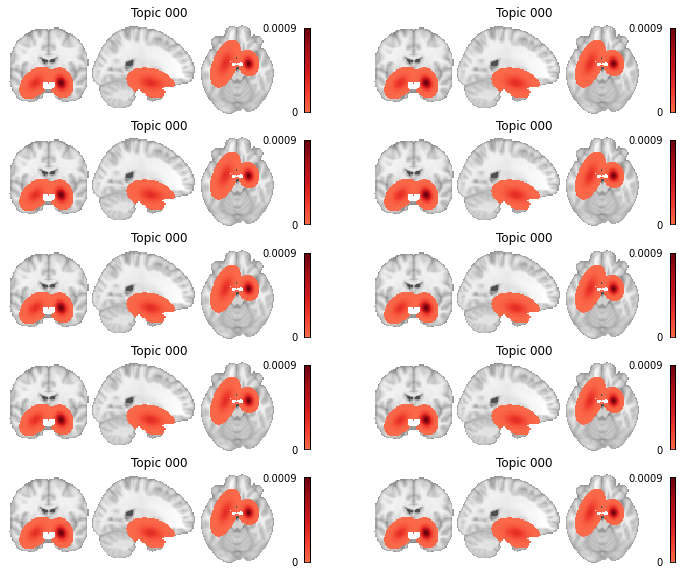

In [14]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 10))

topic_img_4d = neurosynth_dset_first_500.masker.inverse_transform(gclda_model.p_voxel_g_topic_.T)
# Plot first ten topics
topic_counter = 0
for i_row in range(5):
    for j_col in range(2):
        topic_img = image.index_img(topic_img_4d, index=topic_counter)
        display = plotting.plot_stat_map(
            topic_img,
            annotate=False,
            cmap="Reds",
            draw_cross=False,
            figure=fig,
            axes=axes[i_row, j_col],
        )
        axes[i_row, j_col].set_title(f"Topic {str(topic_counter).zfill(3)}")

        colorbar = display._cbar
        colorbar_ticks = colorbar.get_ticks()
        if colorbar_ticks[0] < 0:
            new_ticks = [colorbar_ticks[0], 0, colorbar_ticks[-1]]
        else:
            new_ticks = [colorbar_ticks[0], colorbar_ticks[-1]]
        colorbar.set_ticks(new_ticks, update_ticks=True)

glue("figure_gclda_topics", fig, display=False)

In [15]:
# Here we delete the recent variables for the sake of reducing memory usage
del gclda_model, temp_df, gclda_df, counts_df